# Extract CCD VisitTables in  OGA for Auxtel on 3864
- **associate tract and patches to each visit**
- **loop over observation nights**

 work with Weakly_2024_07
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/01/02
- update : 2024/03/06


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2024_07/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2024_07/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2024_07/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+34187316c4 	current w_2024_07 setup


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

In [8]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None



## Configuration

In [9]:
#filesource_out="ccdVisitTable_202312.csv"
filesource_out="ccdVisitTable_202402.csv"
#filetractpatch_out = 'Latiss_tractspatchs_202312.pickle'

In [10]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

In [11]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [12]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 

In [13]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    assert RAMIN < RAMAX
    assert DECMIN < DECMAX

    flag = (ra >= RAMIN) and (ra<=RAMAX) and (dec>= DECMIN) and (dec <= DECMAX) 
    return flag

## Give the collection

In [14]:
#my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"

In [15]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

## Config

In [16]:
#Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [17]:
Auxtel2023_tracts = [382,383,452,455,
                     3863,3864,
                     5614,5615,5616,5634,5839,
                     #8188,
                     10643,10644]

In [18]:
with open('Latiss_tractspatchs_202402.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [19]:
tracts_patchs_dict

{10644: array([189, 183, 184, 164, 185, 203, 201, 207, 182, 162, 166, 165, 181,
        161, 188, 208, 180, 202]),
 5634: array([ 90, 110,  71, 112,  73, 109,  93,  92,  91,  53,  72,  55,  52,
        111,  54,  74]),
 3863: array([223, 261, 241, 242, 262, 260, 243, 222, 224]),
 452: array([41, 62, 22, 25, 23, 44, 42, 63, 43, 24]),
 5614: array([250, 251, 230, 210, 212, 232, 211, 213, 249, 229, 231]),
 5616: array([355, 358, 316, 338, 356, 336, 357, 337, 317, 335, 315, 334]),
 5615: array([274, 331, 312, 332, 294, 295, 293, 313, 333, 314, 275, 276]),
 5839: array([9, 8, 7]),
 10643: array([190, 171]),
 455: array([51, 52, 15, 33, 14, 53, 34, 13, 32]),
 382: array([343, 344, 342]),
 3864: array([274, 238, 217, 218, 273, 255, 235, 275, 237, 257, 219, 236, 256,
        254, 276, 216]),
 383: array([359, 360])}

In [20]:
#tract_selected = 5615
#patches_selected = [294,313]
#suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]} and {patches_selected[1]}"

### Find tract

In [21]:
tractsInfo_dict = {}
tractsInfoWCS_dict = {}
tractsId_list = list(tracts_patchs_dict.keys())

# loop to select the good tracts
for tractInfo in skymap:
    tractID = tractInfo.getId()
    # is this tract in Auxtel tract list
    if tractID in tractsId_list:
        # keep tractInfo
        tractsInfo_dict[tractID] = tractInfo 
        # keep WCS
        tractsInfoWCS_dict[tractID] = tractInfo.getWcs()


In [22]:
#print(tractsInfo_dict)

In [23]:
#print(tractsInfoWCS_dict)

# Sources

In [24]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=my_collection, where= "instrument='LATISS'")

In [25]:
for i, ref in enumerate(datasetRefs):
    print("========================datasetType = ccdVisitTable ============================================")
    print("fullId..................:",ref.dataId.full)  

========================datasetType = ccdVisitTable ============================================
fullId..................: {instrument: 'LATISS'}


/tmp/ipykernel_18486/3564957682.py:3: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print("fullId..................:",ref.dataId.full)


In [26]:
visit_table = butler.get('visitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
visit_table.head()

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100270,2023051100270,SDSSi_65mm~empty,i,239.963850,-24.048746,-24.048746,170.004124,99.285576,35.972240,54.027760,1.697680,30.0,2023-05-12 01:22:36.150002,60076.057363,2023-05-12 01:22:21.150002,60076.057189


In [27]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
ccd_visit_table.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534


### Compute night obs

In [28]:
ccd_visit_table["nightObs"] =ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)

### Compute datetime to plot vs time

In [29]:
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

### Compute airmass

In [30]:
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

### Find those visits in the selected tract and patches

In [31]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
    tractsId_list = list(tracts_patchs_dict.keys())   
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            wcs = tractsInfoWCS_dict[tractID]
            tractInfo = tractsInfo_dict[tractID] 
            patches_selected = list(tracts_patchs_dict[tractID])
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        

In [32]:
ccd_visit_table[["patchID","tractID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [33]:
ccd_visit_table.head()

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294


## Selection of the tract and patch
- best Patches 236 and 237 for tract 3864

In [34]:
tract_selected = 3864
patch_selected = 236
suptitle = f"CCD visit in tract {tract_selected} and patch {patch_selected}"

In [35]:
#ccd_visit_table["selectedFlag"] = ccd_visit_table[["patchID","tractID"]].apply(lambda x: x[0] == tract_selected and x[1] == patch_selected,axis =1, raw= True )
ccd_visit_table["selectedFlag1"] = ccd_visit_table[["patchID","tractID"]].apply(lambda x: x[0] == tract_selected and x[1] == 236,axis =1, raw= True )
ccd_visit_table["selectedFlag2"] = ccd_visit_table[["patchID","tractID"]].apply(lambda x: x[0] == tract_selected and x[1] == 237,axis =1, raw= True )
ccd_visit_table["selectedFlag"] = ccd_visit_table["selectedFlag1"] | ccd_visit_table["selectedFlag2"]

In [36]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID,selectedFlag1,selectedFlag2,selectedFlag
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.690649,7.814408,11.197219,7.856582,0.026538,0.014041,42,-0.007038,0.000486,0.032627,0.014318,0.107089,0.110564,0.013839,0.879543,2160.236328,0.207786,0.016376,2.679237,0.157862,-24.053747,0,1.761132,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128924,240.029265,-24.062574,239.957876,-23.978569,239.864202,-24.044875,20230511,2023-05-12 01:08:41.302993,1.823818,5615,295,False,False,False
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941334,-24.038378,56.289413,27.925329,7.783146,3.989901,7.472743,0.024001,0.011537,17,0.020877,0.003123,0.037679,0.028327,0.131853,0.174565,0.021897,5.176466,2552.229980,0.905713,0.016508,7.518984,0.243232,-24.038378,0,1.754283,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988739,-23.976095,239.872244,-23.996199,239.893884,-24.100647,240.010470,-24.080526,20230511,2023-05-12 01:10:51.209005,1.801808,5615,295,False,False,False
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.837013,6.324102,28.071854,8.586543,0.026761,0.017073,39,0.007049,-0.012680,0.025506,0.043905,0.010775,0.095402,0.015088,0.304010,1387.484985,0.165707,0.025004,1.068686,0.206713,-24.036848,0,1.425322,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000,1.762794,5615,295,False,False,False
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.765863,8.100543,10.701077,7.854048,0.024562,0.014017,32,-0.001813,-0.007225,0.012738,0.015732,0.153432,0.113233,0.013615,0.492057,2023.047119,0.232399,0.015240,2.803456,0.181321,-24.045512,0,1.825525,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494,1.721301,5615,294,False,False,False
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.847099,6.745777,23.952093,8.440446,0.023946,0.012757,33,-0.011323,0.002748,0.035845,0.022814,-0.030170,0.125044,0.018293,1.152671,1726.039673,0.173889,0.021975,1.252500,0.210590,-24.046364,0,1.520381,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002,1.695170,5615,294,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43134264832,2024013000166,empty~SDSSy_65mm,y,122.428828,-36.166063,5.993765,26.073267,4.577834,14.221478,8.110322,0.012466,0.007235,67,0.005375,-0.003194,0.033592,0.025067,-0.021962,0.087823,0.019033,0.437758,1227.355591,0.024230,0.047718,2.109485,0.008024,-36.166063,0,1.031667,359.999822,2024-01-31 04:14:35.80599

In [37]:
ccd_visit_table_selected = ccd_visit_table[ccd_visit_table["selectedFlag"]]
ccd_visit_table_selected.drop(["selectedFlag"],axis=1,inplace=True) 
ccd_visit_table_selected.drop(["selectedFlag1"],axis=1,inplace=True) 
ccd_visit_table_selected.drop(["selectedFlag2"],axis=1,inplace=True) 
# remove last night in jan
ccd_visit_table_selected = ccd_visit_table_selected[ccd_visit_table_selected["nightObs"]!= 20240130]

/tmp/ipykernel_18486/287940088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected.drop(["selectedFlag"],axis=1,inplace=True)
/tmp/ipykernel_18486/287940088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected.drop(["selectedFlag1"],axis=1,inplace=True)
/tmp/ipykernel_18486/287940088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected.drop(["selectedFlag2"],axis=

In [38]:
ccd_visit_table_selected.head() 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42496813824,2023111500491,SDSSg_65mm~empty,g,122.468449,-36.222238,24.011332,28.035490,6.824482,2.986938,7.421649,0.016613,0.010904,58,0.005843,-0.006674,0.024857,0.020239,0.013503,0.114604,0.016570,0.530975,1182.817017,1.927642,0.021471,10.043732,0.297954,-36.222238,0,1.538134,359.999670,2023-11-16 07:21:40.837995,60264.306723,30.0,2023-11-16 07:21:25.837995,60264.306549,30.2359,4071,3999,122.402161,-36.276077,122.536430,-36.274708,122.534646,-36.168363,122.400560,-36.169731,20231115,2023-11-16 07:21:25.837995,1.094733,3864,237
42496814080,2023111500492,SDSSr_65mm~empty,r,122.468503,-36.222252,23.855349,27.835615,6.629889,4.678271,7.553623,0.012605,0.007200,87,0.003975,-0.001169,0.028610,0.017540,0.013773,0.133706,0.019896,0.196698,1602.367920,0.902391,0.022750,6.412626,0.206182,-36.222252,0,1.494120,359.999677,2023-11-16 07:22:27.471005,60264.307262,30.0,2023-11-16 07:22:12.471005,60264.307089,30.2362,4071,3999,122.402221,-36.276085,122.536479,-36.274714,122.534692,-36.168383,122.400617,-36.169752,20231115,2023-11-16 07:22:12.471005,1.093411,3864,237
42496814336,2023111500493,empty~SDSSi_65mm,i,122.468768,-36.222225,23.693943,27.931004,5.051122,11.874315,7.933243,0.007708,0.003945,128,-0.001332,0.002337,0.023628,0.018296,0.020964,0.128188,0.025112,0.944608,845.998901,0.730161,0.039194,2.526461,0.245788,-36.222225,0,1.138269,359.999732,2023-11-16 07:23:15.790002,60264.307822,30.0,2023-11-16 07:23:00.790002,60264.307648,30.2334,4071,3999,122.402483,-36.276052,122.536744,-36.274679,122.534961,-36.168362,122.400882,-36.169733,20231115,2023-11-16 07:23:00.790002,1.092055,3864,237
42496814592,2023111500494,SDSSg_65mm~empty,g,122.486653,-36.222253,23.419847,28.065121,5.341274,2.941312,7.387998,0.012267,0.006549,88,-0.001282,-0.005128,0.017276,0.023815,0.037130,0.102247,0.018709,1.317342,789.522827,3.374933,0.035052,10.199529,0.314669,-36.222253,0,1.203799,359.999718,2023-11-16 07:24:42.061498,60264.308820,30.0,2023-11-16 07:24:27.061498,60264.308647,30.2471,4071,3999,122.420369,-36.276092,122.554632,-36.274719,122.552847,-36.168378,122.418766,-36.169748,20231115,2023-11-16 07:24:27.061498,1.089779,3864,237
42496814848,2023111500495,SDSSr_65mm~empty,r,122.486693,-36.222281,23.264572,27.845366,4.899587,4.828850,7.518532,0.011678,0.006895,120,-0.002766,-0.006500,0.019894,0.027576,0.006466,0.130650,0.026340,1.019226,680.722656,1.629785,0.041656,6.212659,0.209918,-36.222281,0,1.104168,359.999697,2023-11-16 07:25:28.539005,60264.309358,30.0,2023-11-16 07:25:13.539005,60264.309184,30.2276,4071,3999,122.420412,-36.276117,122.554666,-36.274740,122.552883,-36.168409,122.418810,-36.169784,20231115,2023-11-16 07:25:13.539005,1.088506,3864,237


In [39]:
ccd_visit_table_selected.tail() 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42807202304,2023122200530,empty~SDSSy_65mm,y,122.545526,-36.165448,6.549605,26.290859,4.711883,12.191914,7.896527,0.010315,0.005959,78,0.007204,-0.000844,0.047499,0.040839,-0.017179,0.074325,0.015582,0.742619,929.969177,0.039831,0.045041,2.460647,0.011980,-36.165448,0,1.061916,359.999595,2023-12-23 06:35:11.432498,60301.274438,30.0,2023-12-23 06:34:56.432498,60301.274264,30.2507,4071,3999,122.479305,-36.219306,122.613466,-36.217891,122.611656,-36.111553,122.477677,-36.112967,20231222,2023-12-23 06:34:56.432498,1.006569,3864,236
42807202560,2023122200531,SDSSg_65mm~empty,g,122.563456,-36.165165,6.431128,28.088020,5.246803,5.761377,7.572865,0.011523,0.005004,86,-0.005588,0.003802,0.035207,0.019956,-0.010841,0.062867,0.011942,0.732192,846.448120,1.862516,0.036325,5.207088,0.328226,-36.165165,0,1.182464,0.000232,2023-12-23 06:36:43.743997,60301.275506,30.0,2023-12-23 06:36:28.743997,60301.275333,30.2338,4071,3999,122.497235,-36.219026,122.631392,-36.217608,122.629586,-36.111269,122.495611,-36.112685,20231222,2023-12-23 06:36:28.743997,1.006333,3864,236
42807202816,2023122200532,SDSSr_65mm~empty,r,122.563505,-36.165100,6.373718,27.858763,4.834333,7.192895,7.660575,0.009291,0.004811,113,-0.005274,0.001947,0.060412,0.040494,-0.058958,0.081592,0.016754,0.594035,771.935486,1.151949,0.042788,4.170783,0.215163,-36.165100,0,1.089414,0.000467,2023-12-23 06:37:30.228995,60301.276044,30.0,2023-12-23 06:37:15.228995,60301.275871,30.2366,4071,3999,122.497287,-36.218953,122.631438,-36.217536,122.629632,-36.111211,122.495663,-36.112625,20231222,2023-12-23 06:37:15.228995,1.006219,3864,236
42807203072,2023122200533,SDSSz_65mm~empty,z,122.563568,-36.165076,6.319651,27.357218,4.971608,13.501398,8.000125,0.012626,0.007451,105,0.001552,-0.000986,0.025685,0.028979,0.005215,0.057619,0.011603,0.495931,815.876160,0.230358,0.040458,2.221992,0.085415,-36.165076,0,1.120384,359.999830,2023-12-23 06:38:17.021494,60301.276586,30.0,2023-12-23 06:38:02.021494,60301.276412,30.2448,4071,3999,122.497348,-36.218927,122.631504,-36.217517,122.629698,-36.111189,122.495724,-36.112598,20231222,2023-12-23 06:38:02.021494,1.006114,3864,236
42807203328,2023122200534,empty~SDSSy_65mm,y,122.563897,-36.164977,6.267745,26.264879,4.478357,10.688223,7.820725,0.012417,0.007360,82,0.020967,-0.007823,0.046750,0.032935,-0.018582,0.069270,0.015261,0.813846,699.402832,0.047947,0.049861,2.806828,0.011420,-36.164977,0,1.009249,359.999962,2023-12-23 06:39:05.384000,60301.277146,30.0,2023-12-23 06:38:50.384000,60301.276972,30.2285,4071,3999,122.497684,-36.218832,122.631839,-36.217418,122.630019,-36.111085,122.496046,-36.112497,20231222,2023-12-23 06:38:50.384000,1.006013,3864,236


In [40]:
ccd_visit_table_selected.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'effTime',
       'effTimePsfSigmaScale', 'effTimeSkyBgScale', 'effTimeZeroPointScale',
       'decl', 'detector', 'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD',
       'expTime', 'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize',
       'llcra', 'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra',
       'lrcdec', 'nightObs', 'Time', 'airmass', 'patchID', 'tractID'],
      dtype='object')

In [41]:
df = ccd_visit_table_selected

In [42]:
df["nightObs"].unique()

array([20231115, 20231116, 20231120, 20231121, 20231127, 20231128,
       20231129, 20231130, 20231204, 20231205, 20231206, 20231211,
       20231214, 20231215, 20231220, 20231221, 20231222])

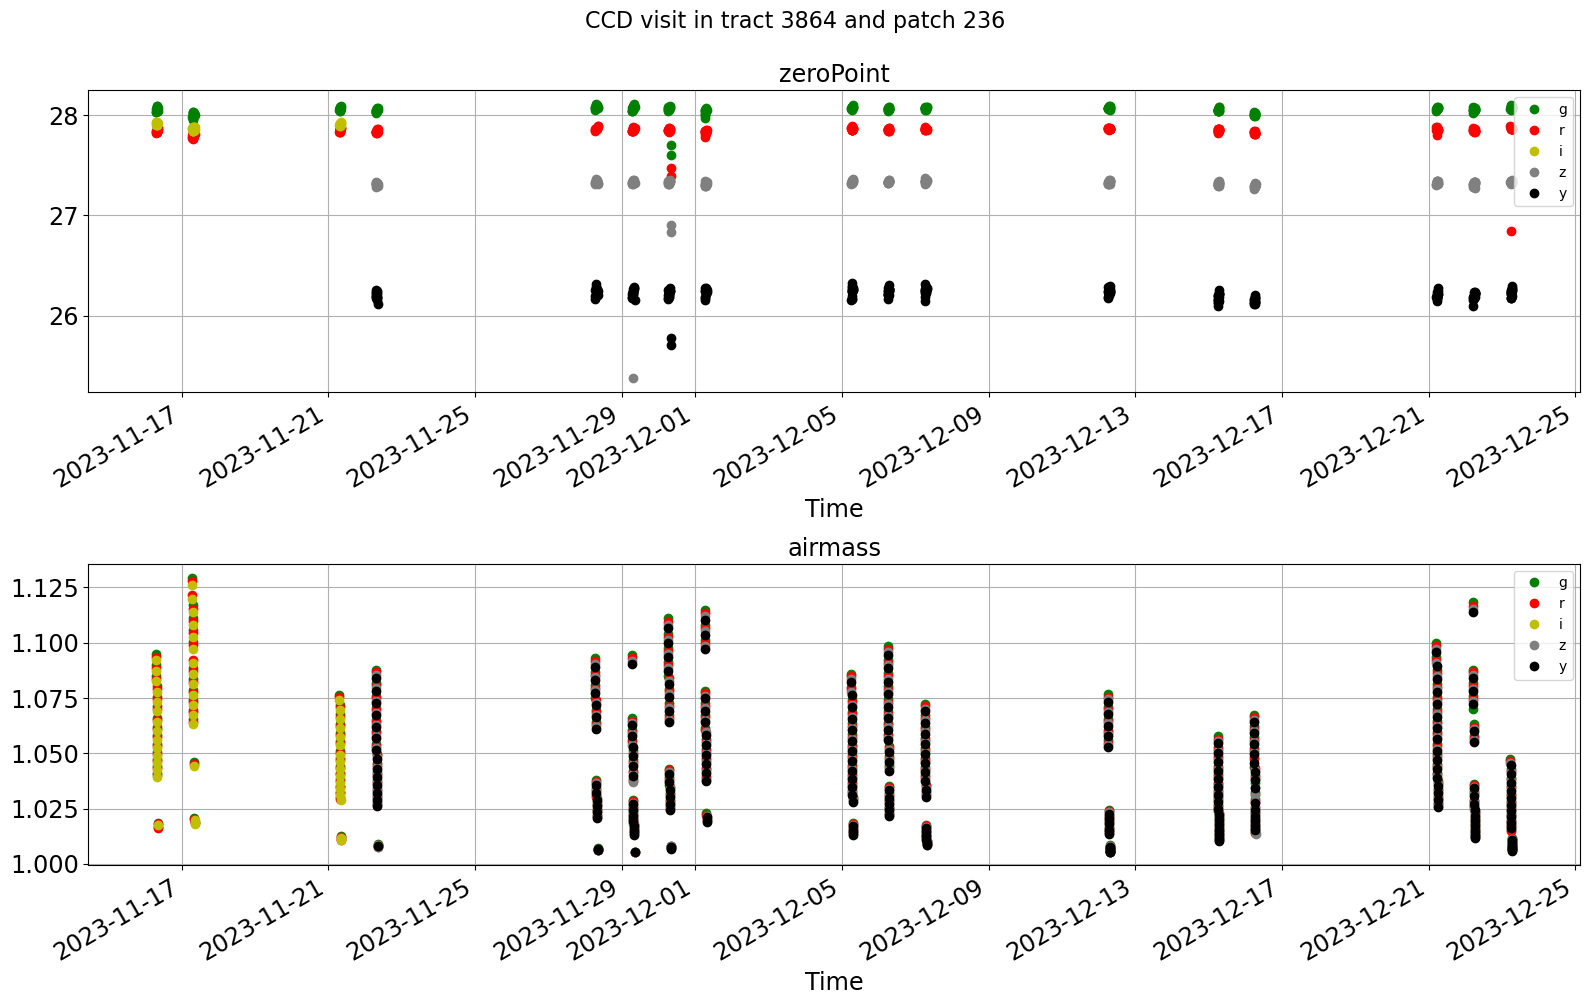

In [43]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,label="g")
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,label="r")
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,label="i")
df[df["band"]=="z"].plot(x="Time",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
df[df["band"]=="y"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_title("zeroPoint")


df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,label="g")
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,label="r")
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,label="i")
df[df["band"]=="z"].plot(x="Time",y="airmass",marker='o',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
df[df["band"]=="y"].plot(x="Time",y="airmass",marker='o',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_title("airmass")


#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Plot number of visit per day

### Plot number of visit per day for patch 236

In [44]:
ccd_visit_table_selected

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,airmass,patchID,tractID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42496813824,2023111500491,SDSSg_65mm~empty,g,122.468449,-36.222238,24.011332,28.035490,6.824482,2.986938,7.421649,0.016613,0.010904,58,0.005843,-0.006674,0.024857,0.020239,0.013503,0.114604,0.016570,0.530975,1182.817017,1.927642,0.021471,10.043732,0.297954,-36.222238,0,1.538134,359.999670,2023-11-16 07:21:40.837995,60264.306723,30.0,2023-11-16 07:21:25.837995,60264.306549,30.2359,4071,3999,122.402161,-36.276077,122.536430,-36.274708,122.534646,-36.168363,122.400560,-36.169731,20231115,2023-11-16 07:21:25.837995,1.094733,3864,237
42496814080,2023111500492,SDSSr_65mm~empty,r,122.468503,-36.222252,23.855349,27.835615,6.629889,4.678271,7.553623,0.012605,0.007200,87,0.003975,-0.001169,0.028610,0.017540,0.013773,0.133706,0.019896,0.196698,1602.367920,0.902391,0.022750,6.412626,0.206182,-36.222252,0,1.494120,359.999677,2023-11-16 07:22:27.471005,60264.307262,30.0,2023-11-16 07:22:12.471005,60264.307089,30.2362,4071,3999,122.402221,-36.276085,122.536479,-36.274714,122.534692,-36.168383,122.400617,-36.169752,20231115,2023-11-16 07:22:12.471005,1.093411,3864,237
42496814336,2023111500493,empty~SDSSi_65mm,i,122.468768,-36.222225,23.693943,27.931004,5.051122,11.874315,7.933243,0.007708,0.003945,128,-0.001332,0.002337,0.023628,0.018296,0.020964,0.128188,0.025112,0.944608,845.998901,0.730161,0.039194,2.526461,0.245788,-36.222225,0,1.138269,359.999732,2023-11-16 07:23:15.790002,60264.307822,30.0,2023-11-16 07:23:00.790002,60264.307648,30.2334,4071,3999,122.402483,-36.276052,122.536744,-36.274679,122.534961,-36.168362,122.400882,-36.169733,20231115,2023-11-16 07:23:00.790002,1.092055,3864,237
42496814592,2023111500494,SDSSg_65mm~empty,g,122.486653,-36.222253,23.419847,28.065121,5.341274,2.941312,7.387998,0.012267,0.006549,88,-0.001282,-0.005128,0.017276,0.023815,0.037130,0.102247,0.018709,1.317342,789.522827,3.374933,0.035052,10.199529,0.314669,-36.222253,0,1.203799,359.999718,2023-11-16 07:24:42.061498,60264.308820,30.0,2023-11-16 07:24:27.061498,60264.308647,30.2471,4071,3999,122.420369,-36.276092,122.554632,-36.274719,122.552847,-36.168378,122.418766,-36.169748,20231115,2023-11-16 07:24:27.061498,1.089779,3864,237
42496814848,2023111500495,SDSSr_65mm~empty,r,122.486693,-36.222281,23.264572,27.845366,4.899587,4.828850,7.518532,0.011678,0.006895,120,-0.002766,-0.006500,0.019894,0.027576,0.006466,0.130650,0.026340,1.019226,680.722656,1.629785,0.041656,6.212659,0.209918,-36.222281,0,1.104168,359.999697,2023-11-16 07:25:28.539005,60264.309358,30.0,2023-11-16 07:25:13.539005,60264.309184,30.2276,4071,3999,122.420412,-36.276117,122.554666,-36.274740,122.552883,-36.168409,122.418810,-36.169784,20231115,2023-11-16 07:25:13.539005,1.088506,3864,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42807202304,2023122200530,empty~SDSSy_65mm,y,122.545526,-36.165448,6.549605,26.290859,4.711883,12.191914,7.896527,0.010315,0.005959,78,0.007204,-0.000844,0.047499,0.040839,-0.017179,0.074325,0.015582,0.742619,929.969177,0.039831,0.045041,2.460647,0.011980,-36.165448,0,1.061916,359.999595,2023-12-23 06:35:11.432498,60301.274438,30.0,2023-12-23 06:34:56.432498,60301.274264,30.2507,4071,3999,122.479305,-36.219306,122.613466,-36.217891,122.611656,-36.111553,122.

/tmp/ipykernel_18486/3037005433.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table_selected.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=True,sharex=True)


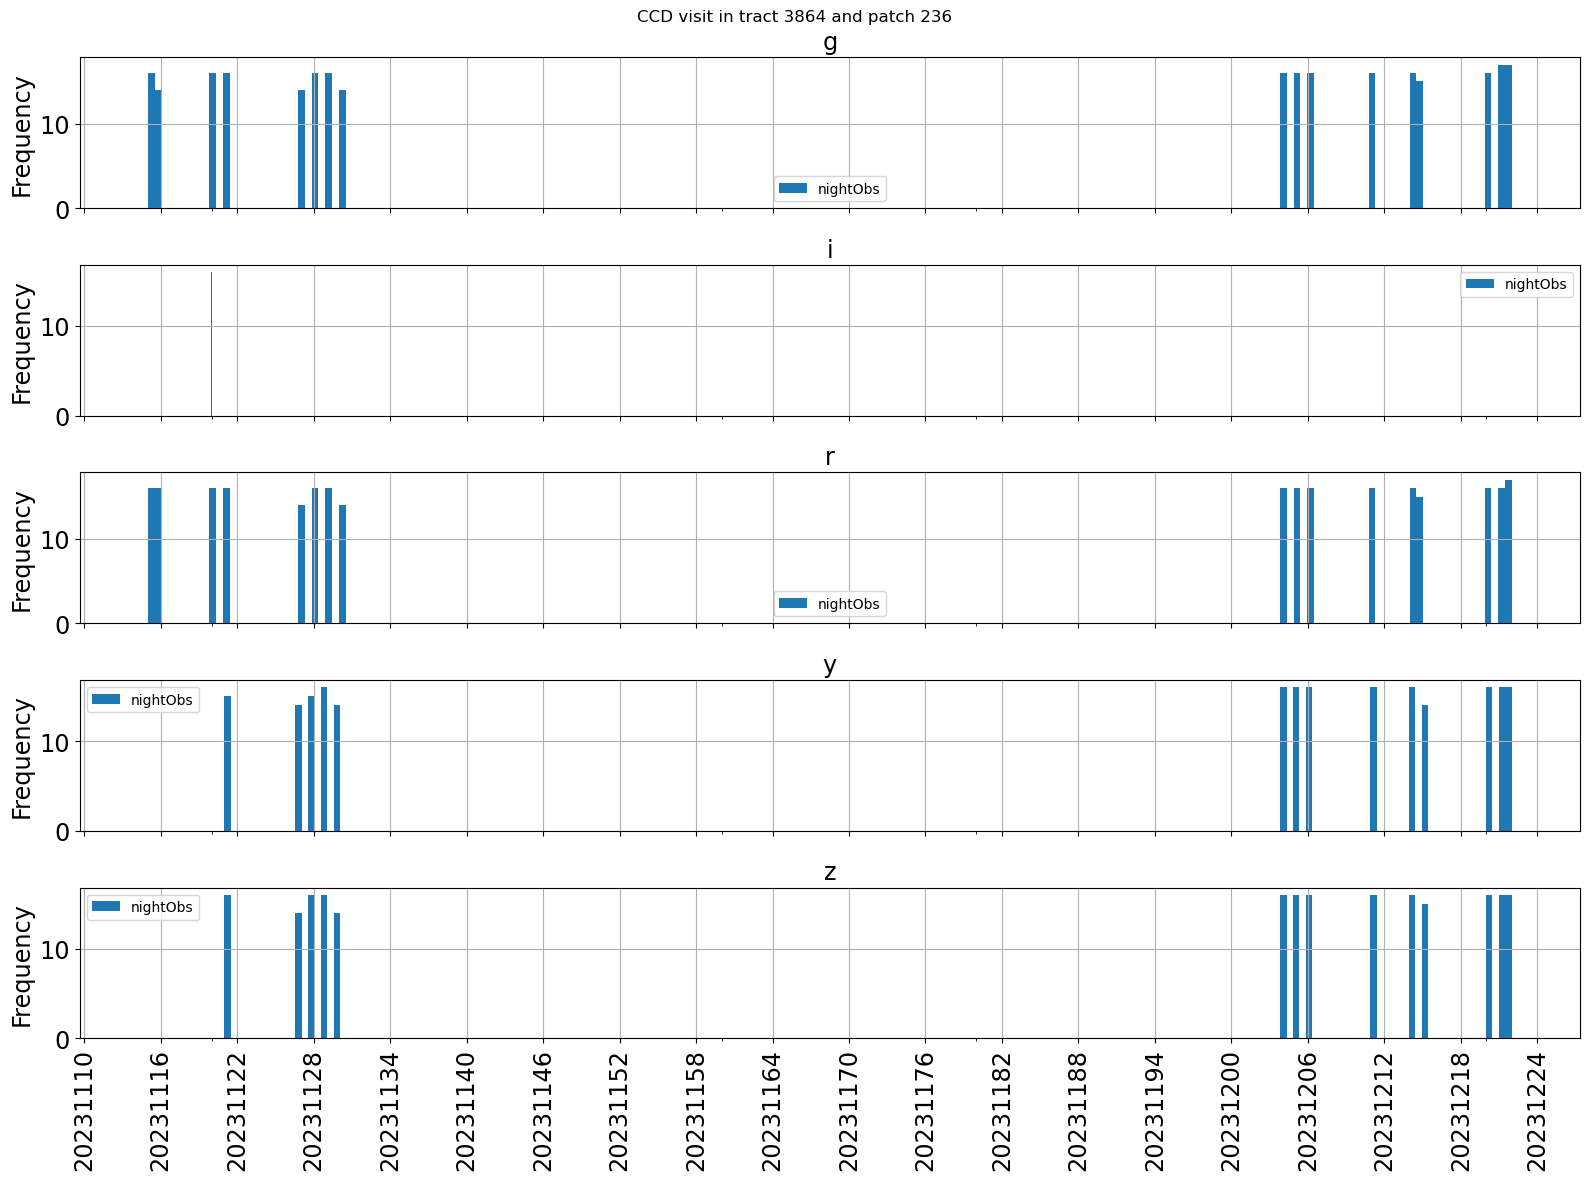

In [45]:

import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,12))
ccd_visit_table_selected.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=True,sharex=True)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [46]:
ccd_visit_table_counts_byband = ccd_visit_table_selected.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_byband.name = "countVisitperBandperNight" 
ccd_visit_table_counts_byband

nightObs  band
20231115  g       16
          i       15
          r       16
20231116  g       14
          i       16
                  ..
20231221  z       16
20231222  g       17
          r       17
          y       16
          z       16
Name: countVisitperBandperNight, Length: 65, dtype: int64

In [47]:
ccd_visit_table_counts = ccd_visit_table_selected.groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts.name = "countVisitperNight" 
ccd_visit_table_counts

nightObs
20231115    47
20231116    46
20231120    48
20231121    63
20231127    56
20231128    63
20231129    64
20231130    56
20231204    64
20231205    64
20231206    64
20231211    64
20231214    64
20231215    59
20231220    64
20231221    65
20231222    66
Name: countVisitperNight, dtype: int64

## Loop on all nights

In [48]:
all_night_obs = ccd_visit_table_selected['nightObs'].unique()
all_night_obs

array([20231115, 20231116, 20231120, 20231121, 20231127, 20231128,
       20231129, 20231130, 20231204, 20231205, 20231206, 20231211,
       20231214, 20231215, 20231220, 20231221, 20231222])

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


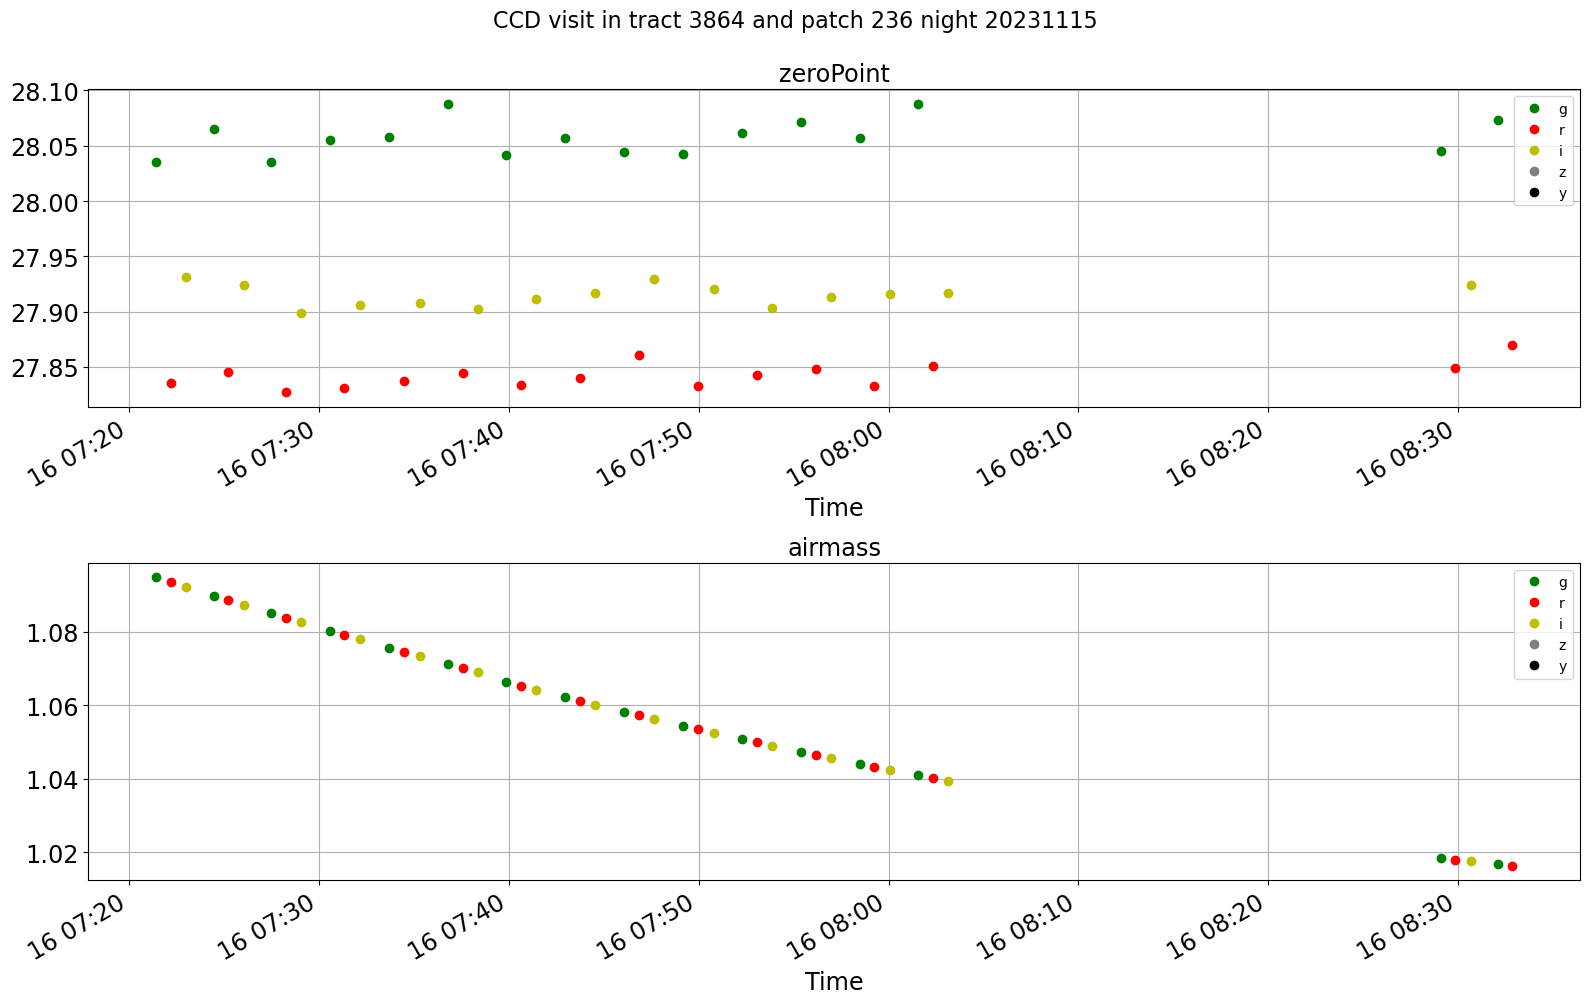

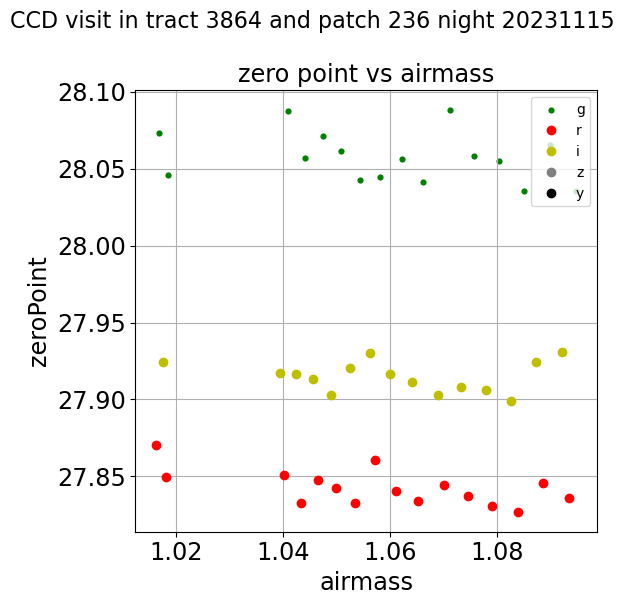

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


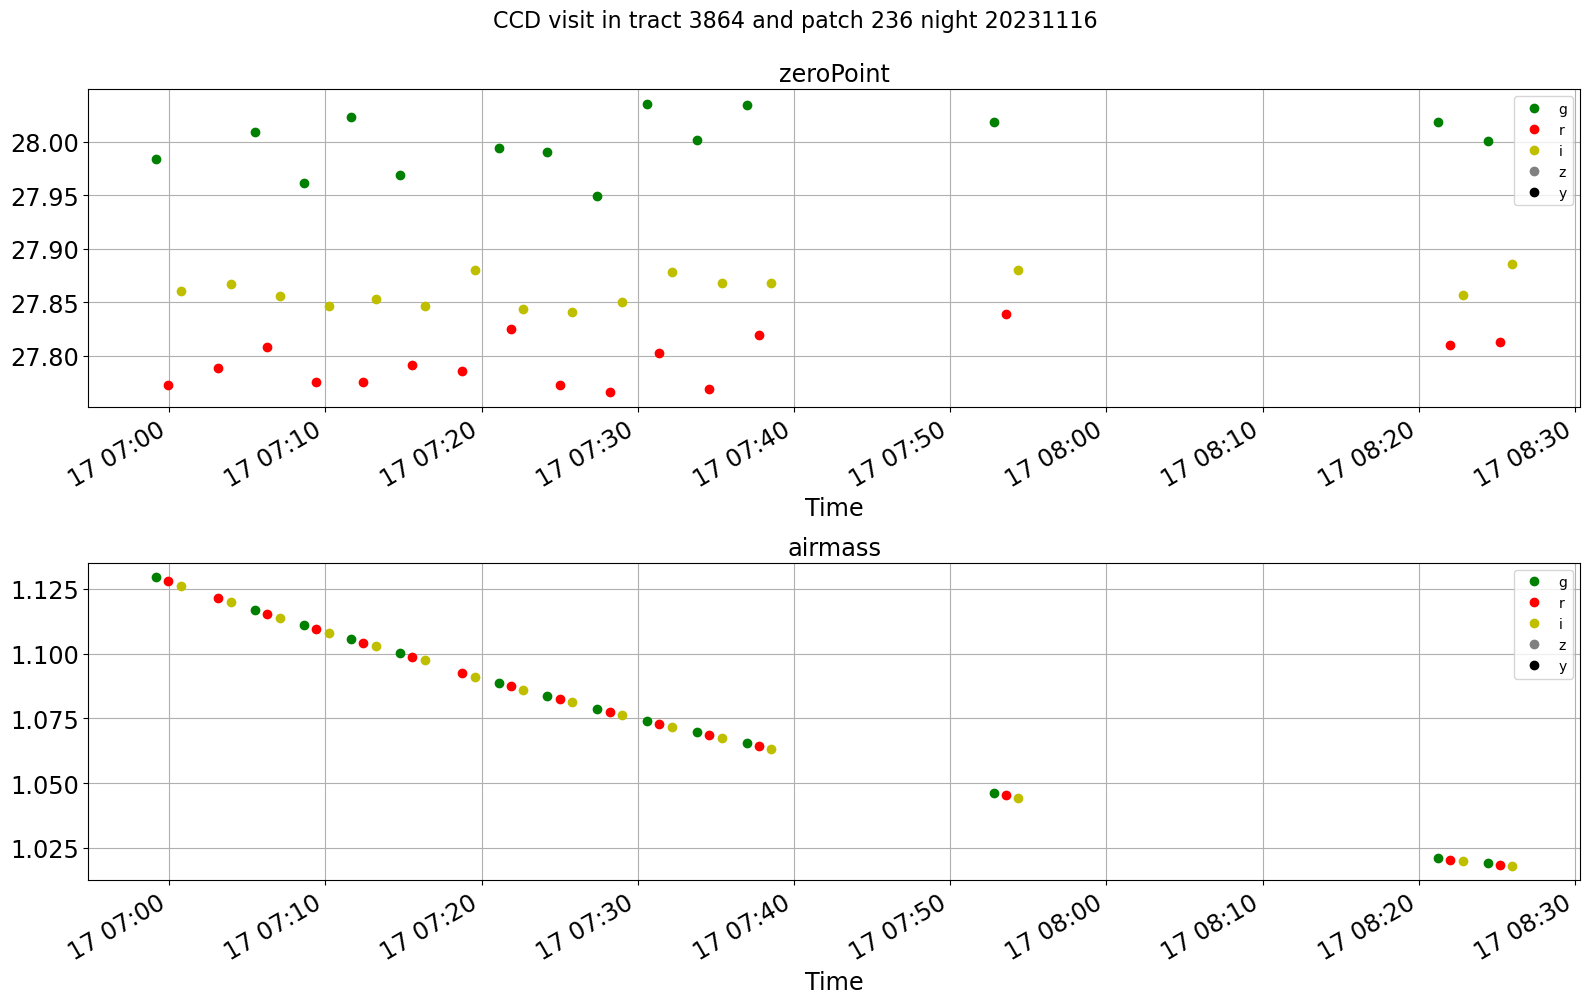

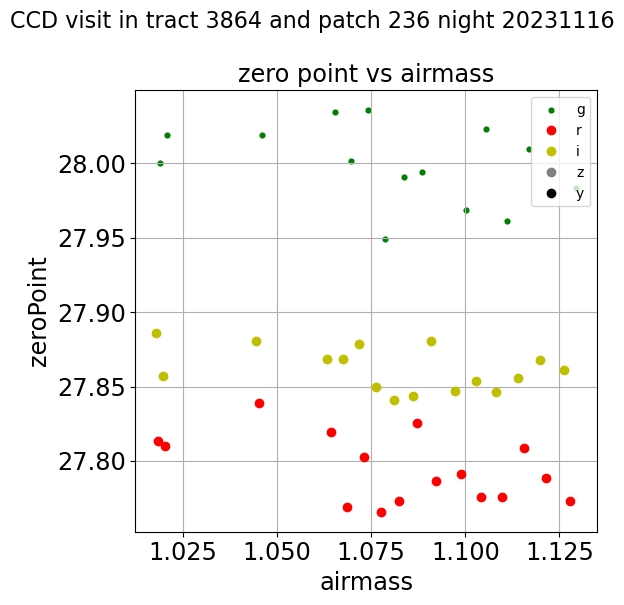

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


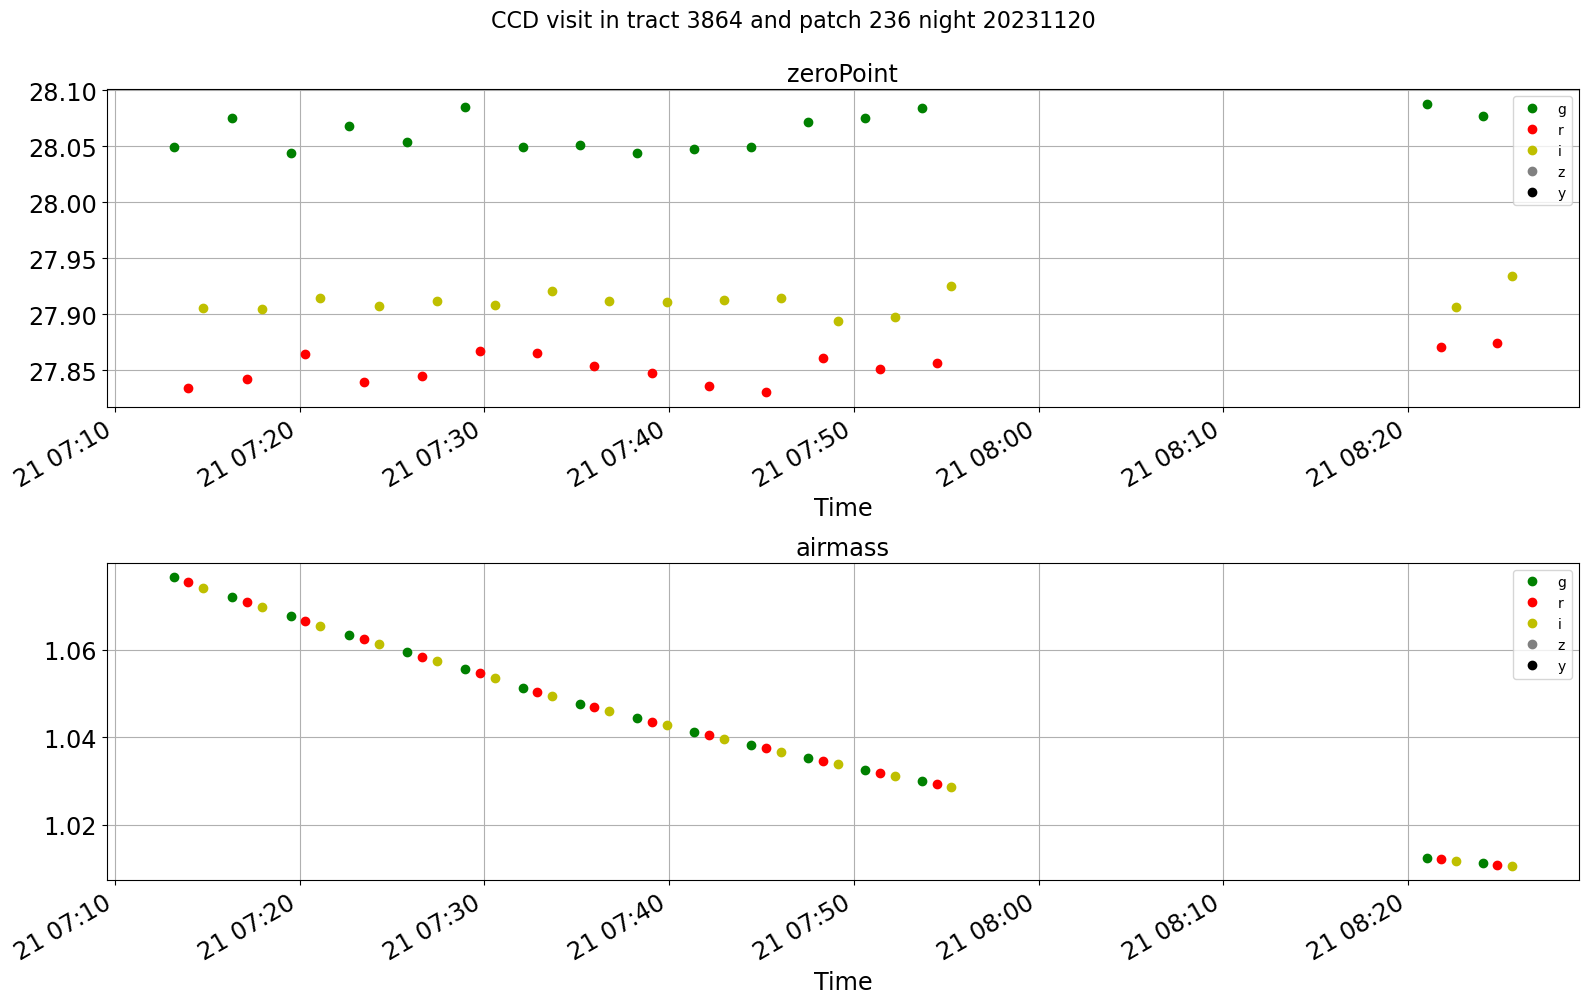

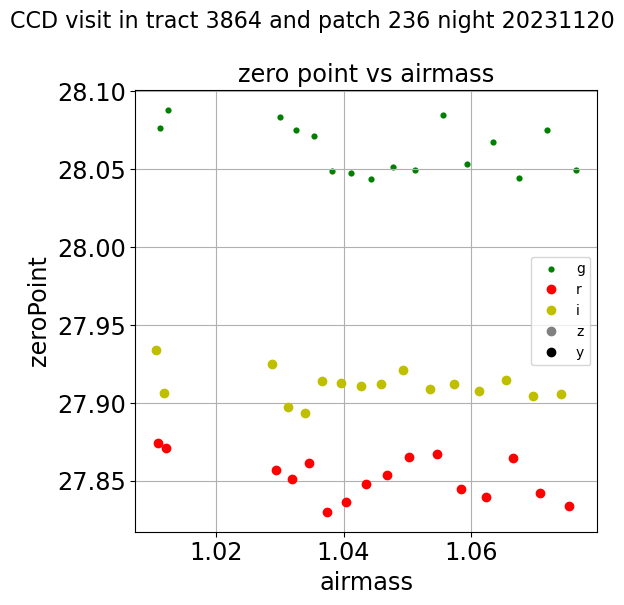

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


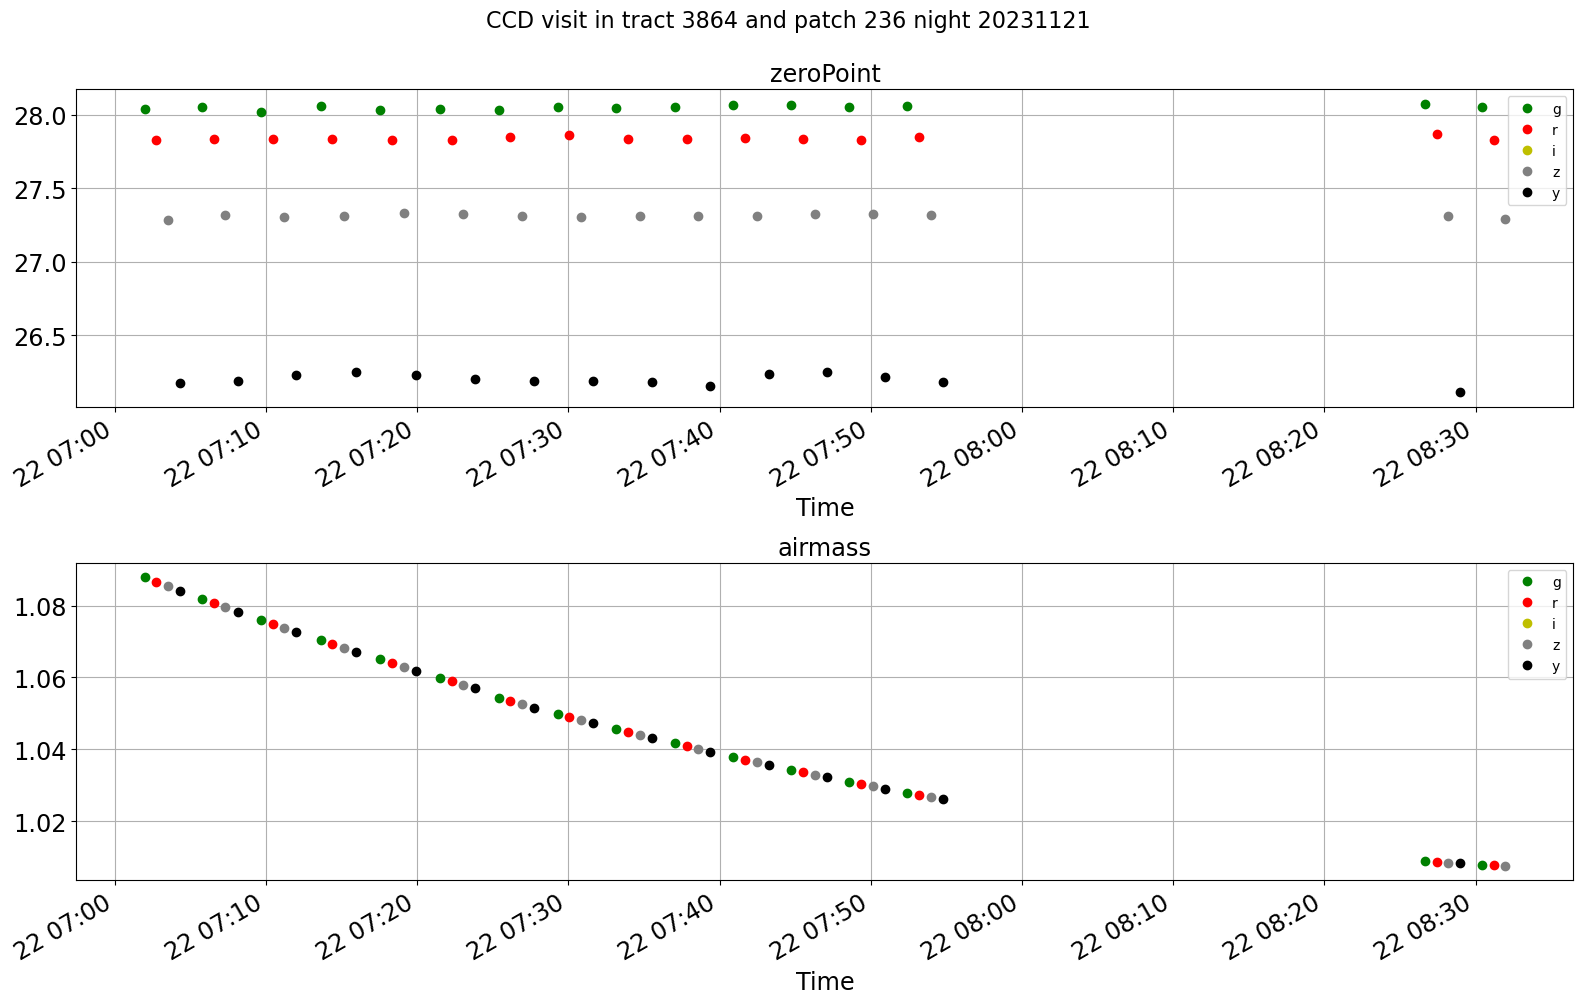

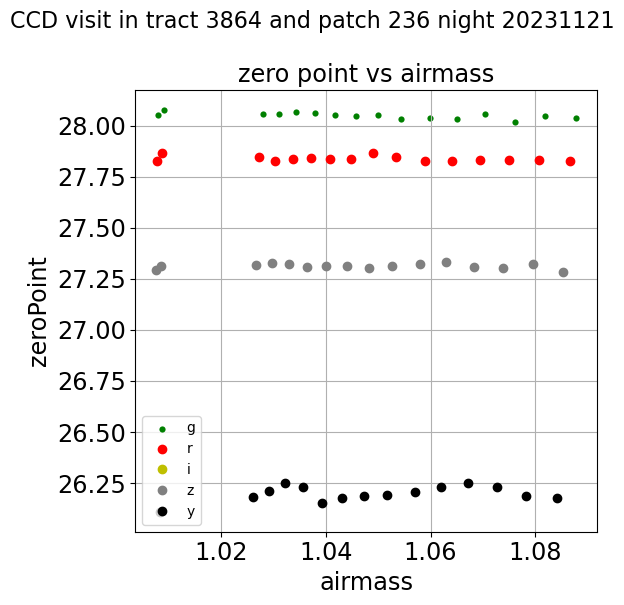

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


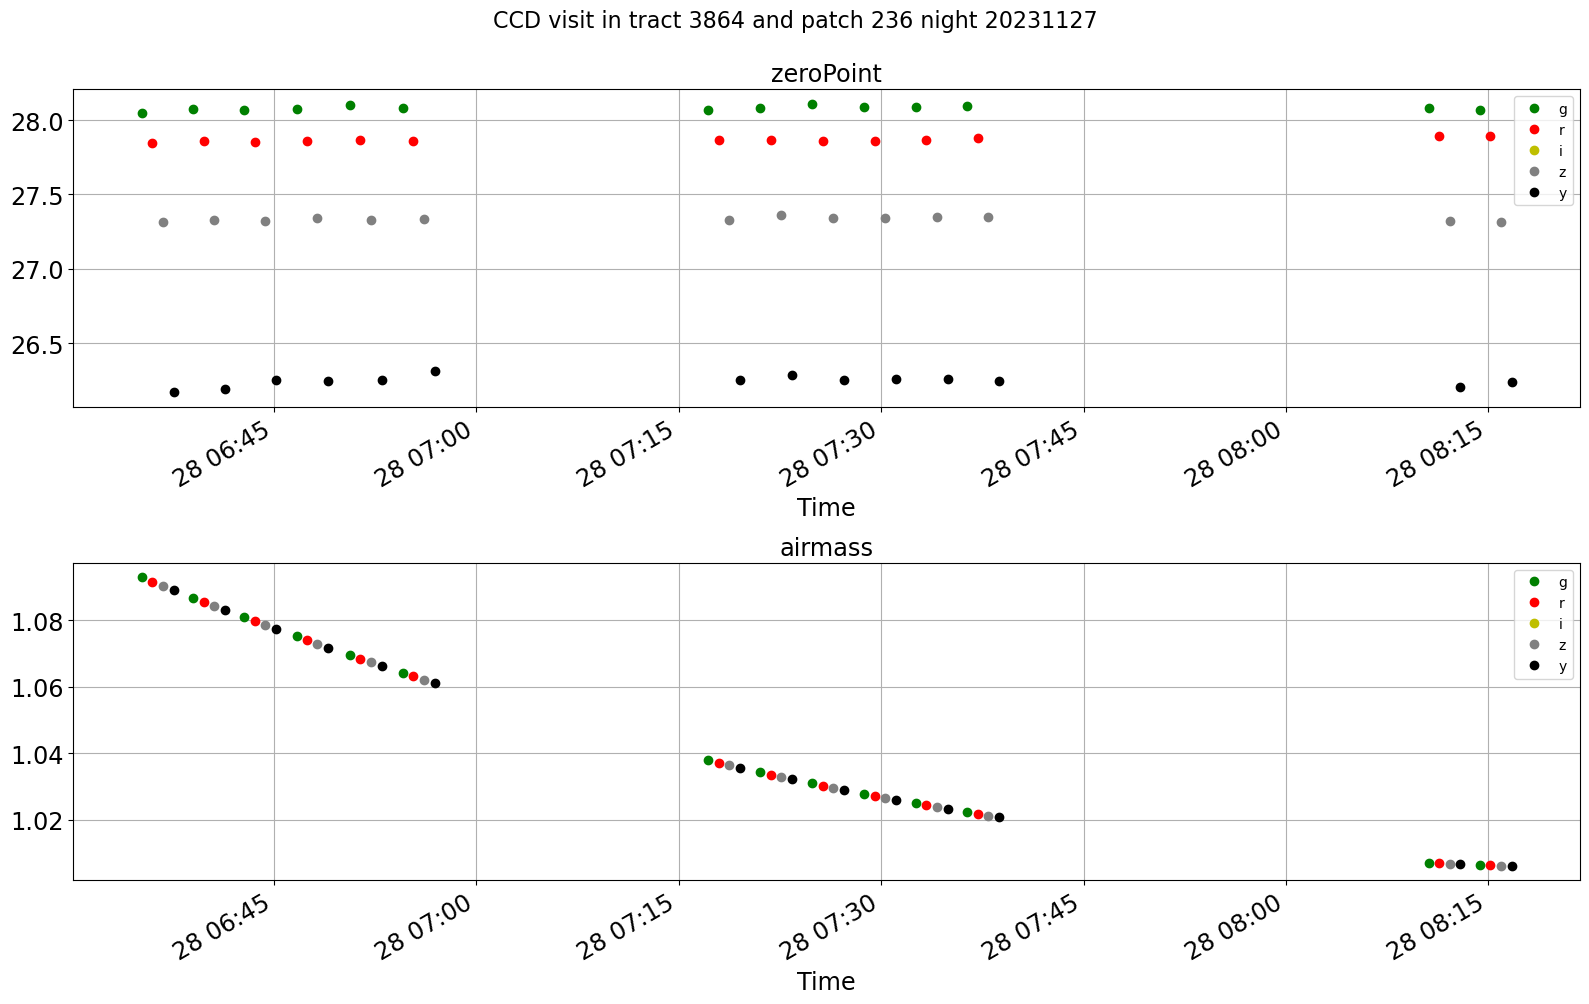

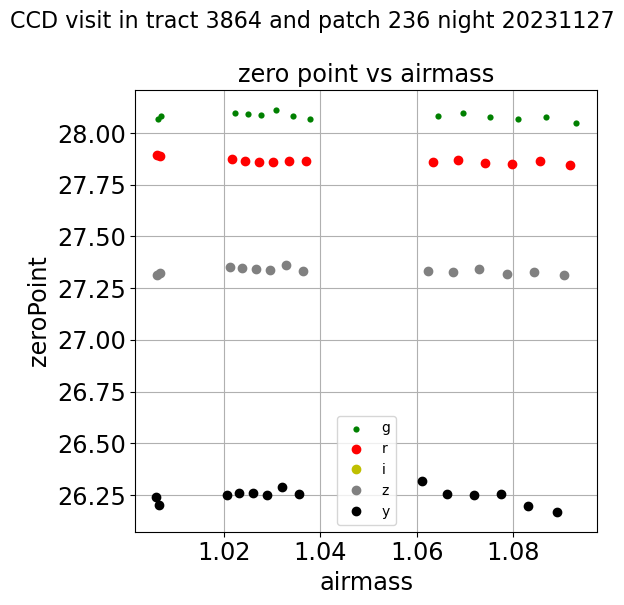

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


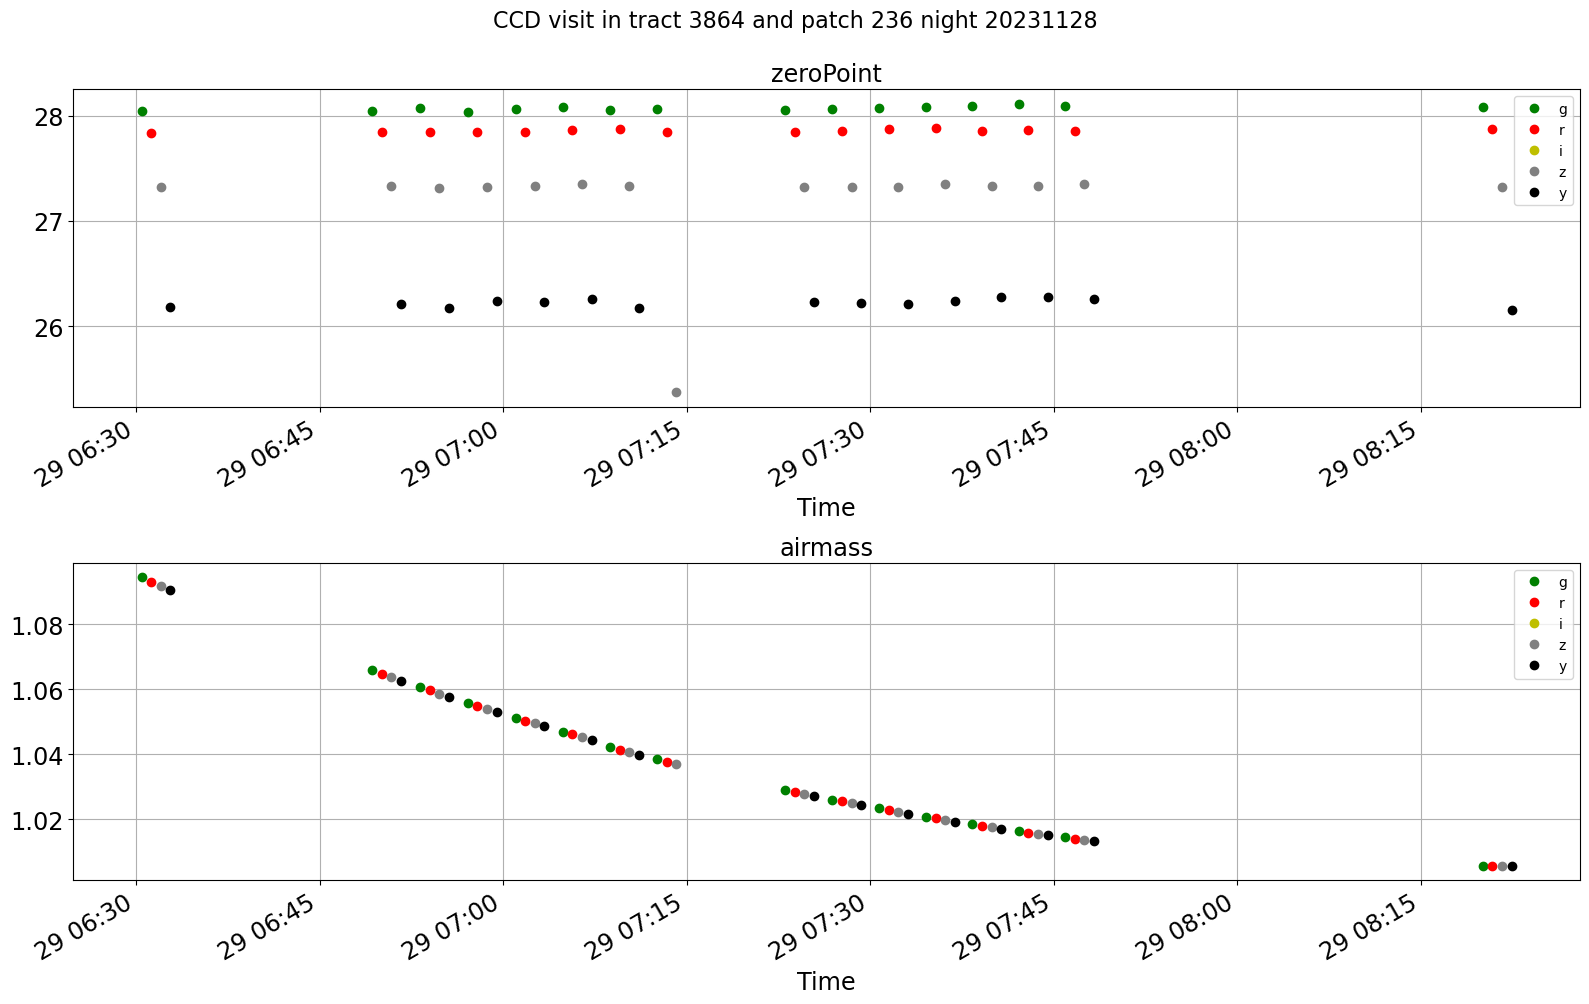

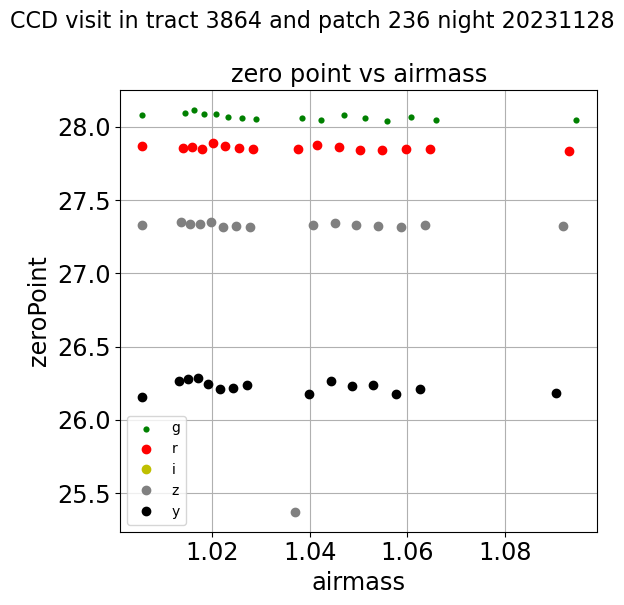

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


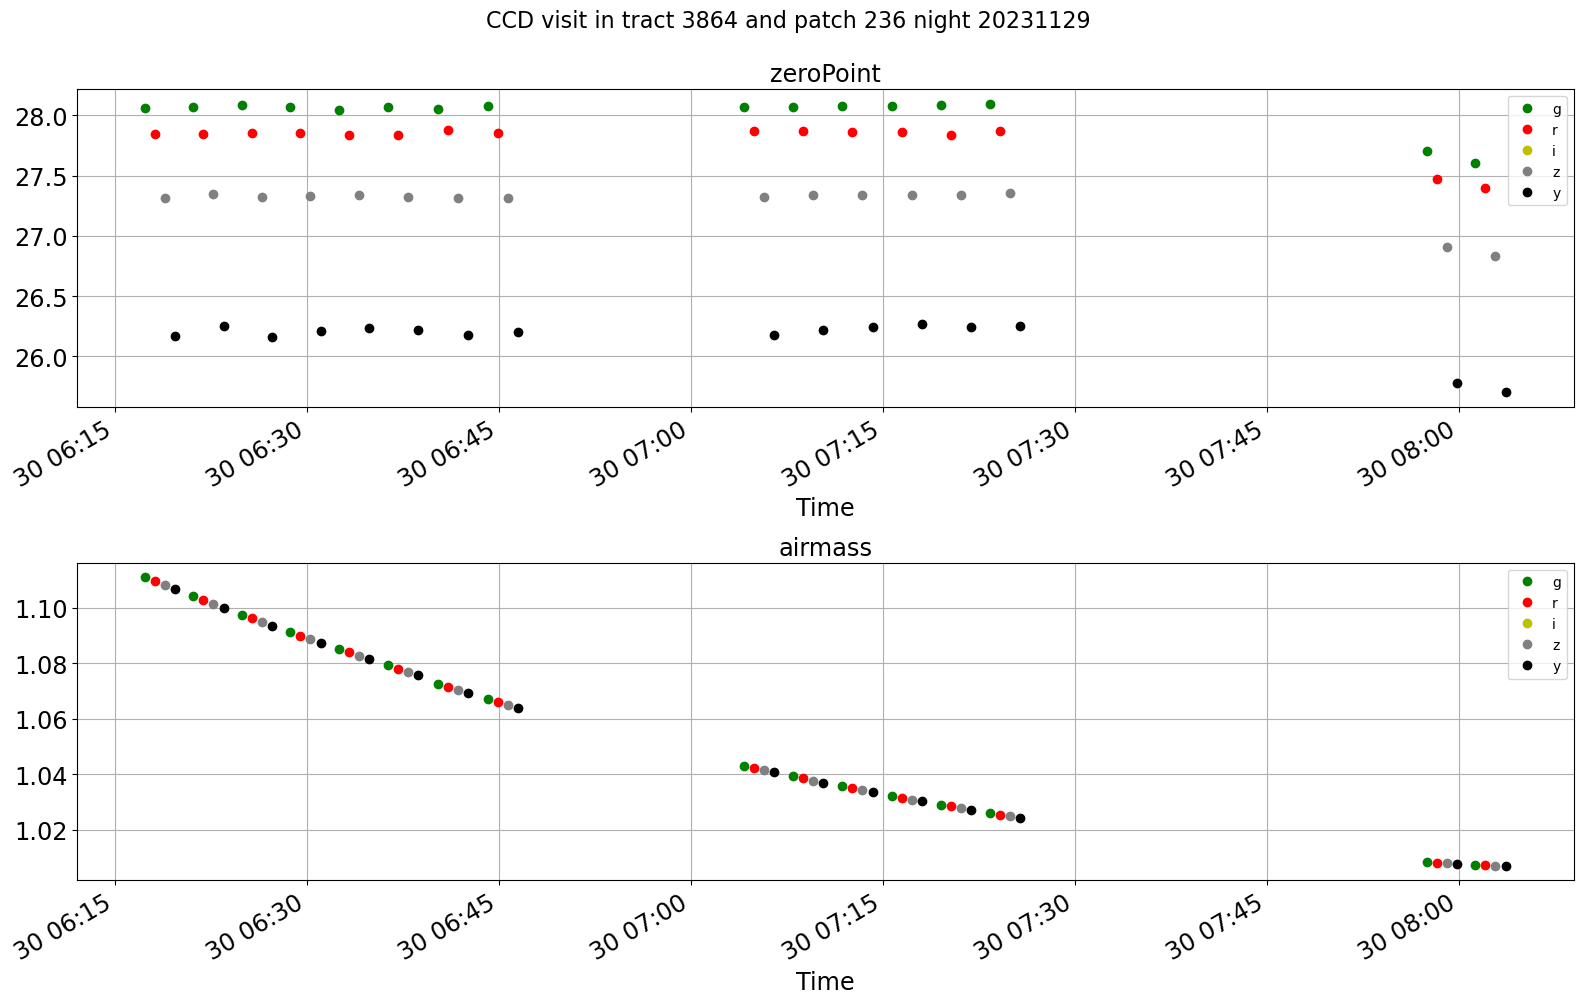

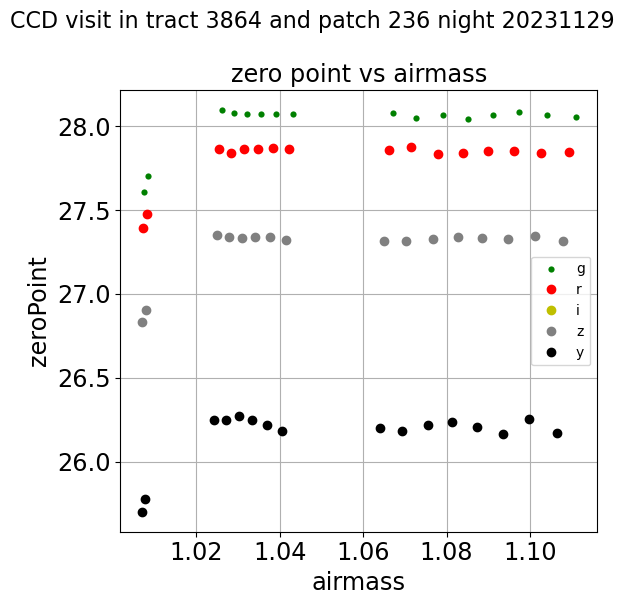

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


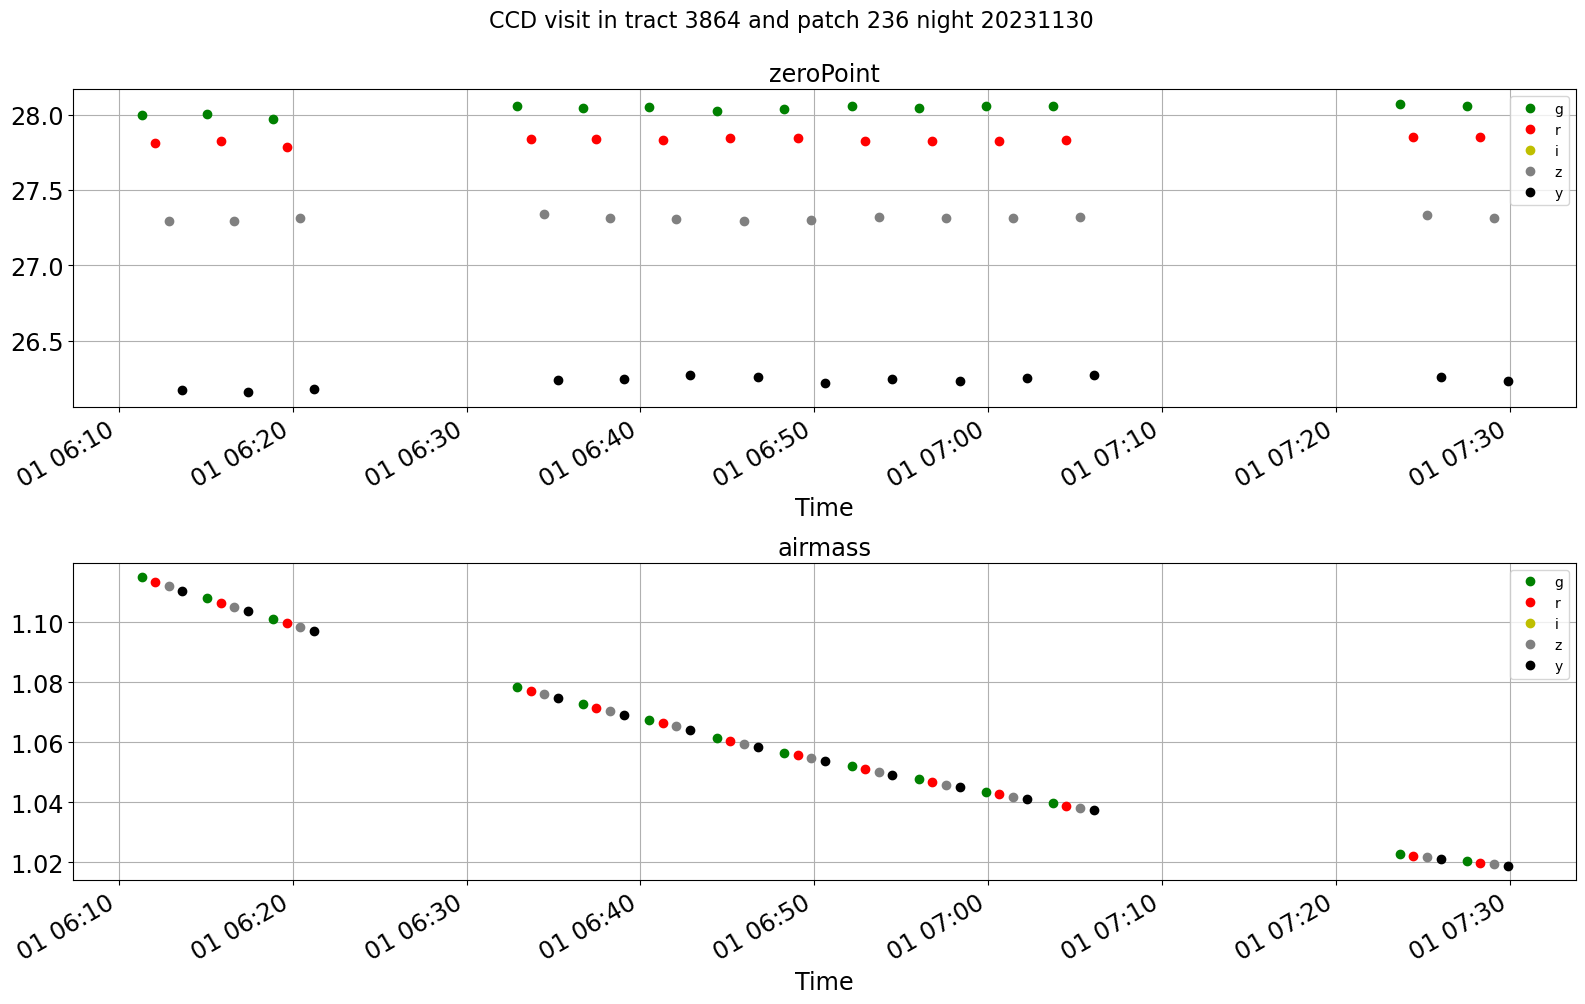

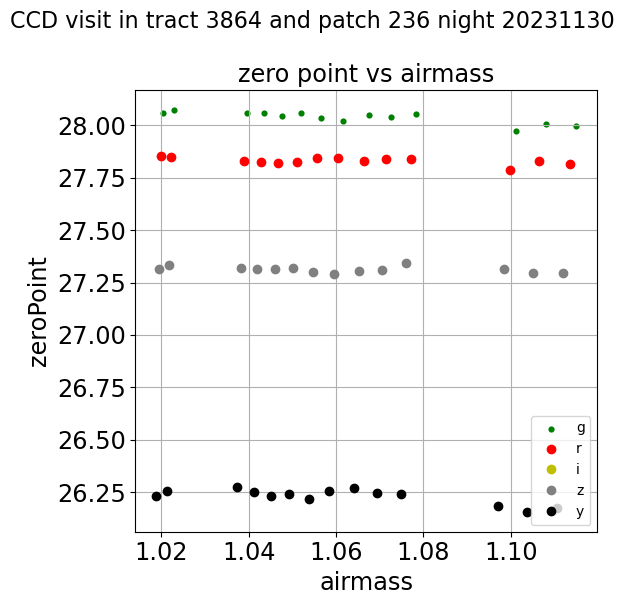

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


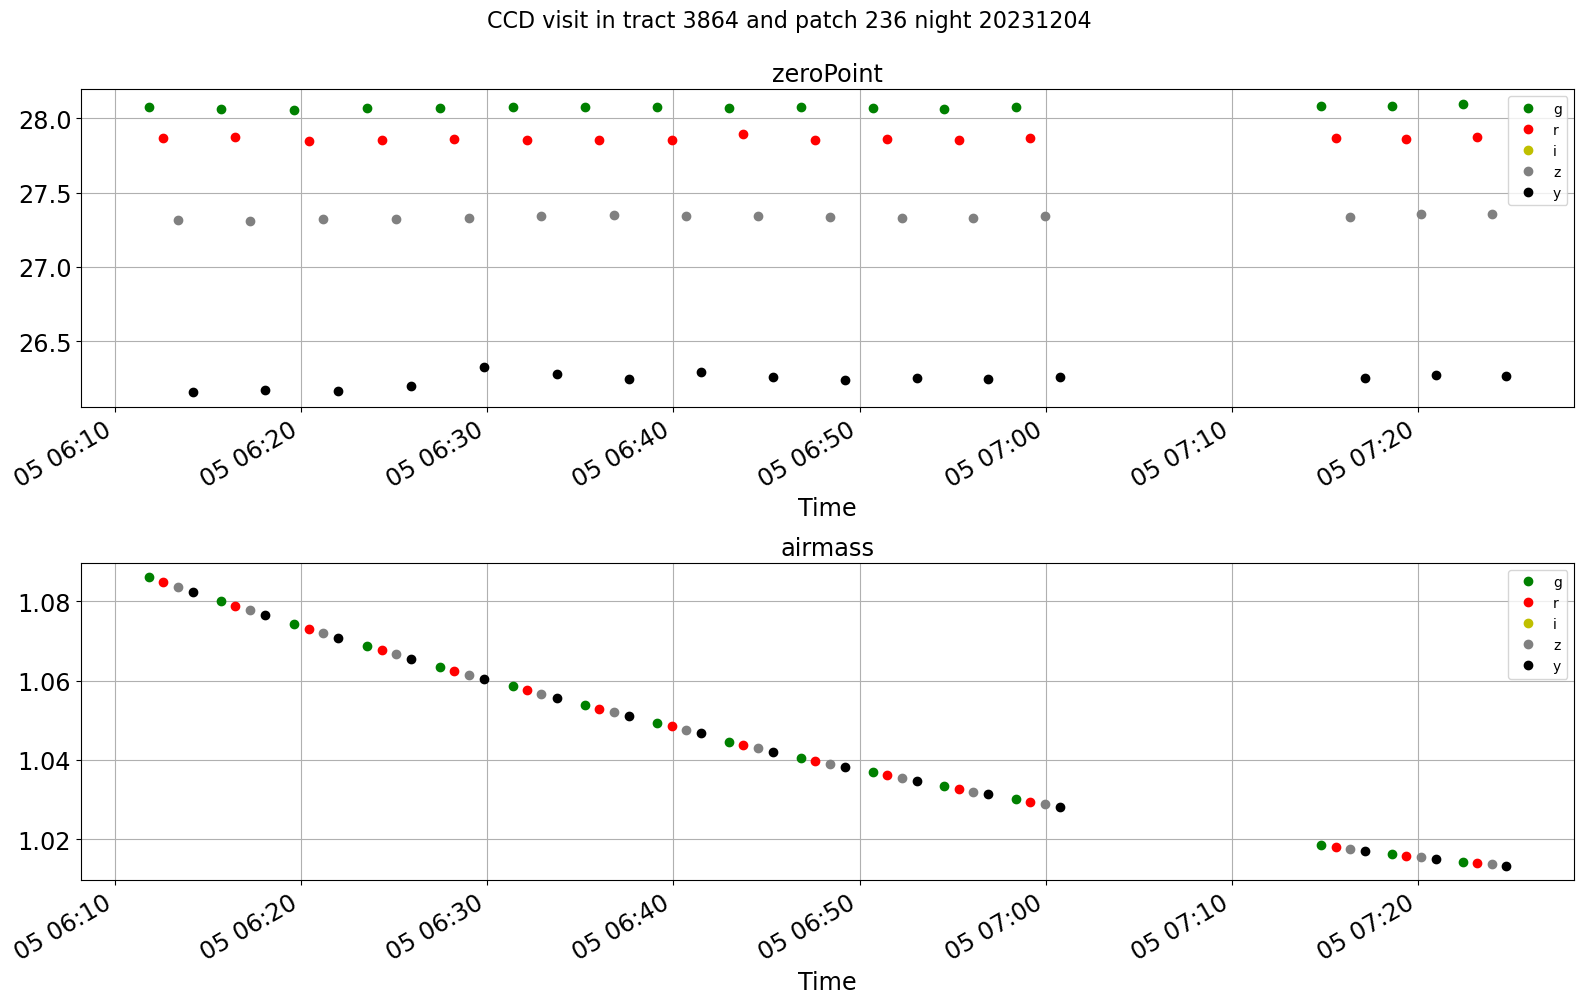

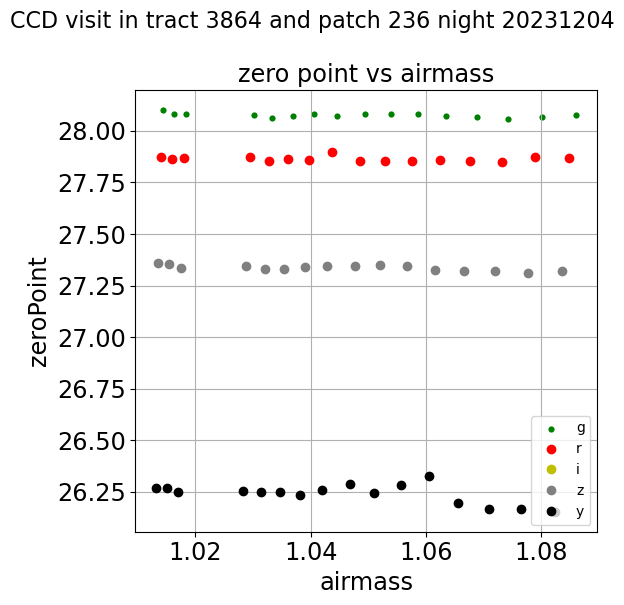

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


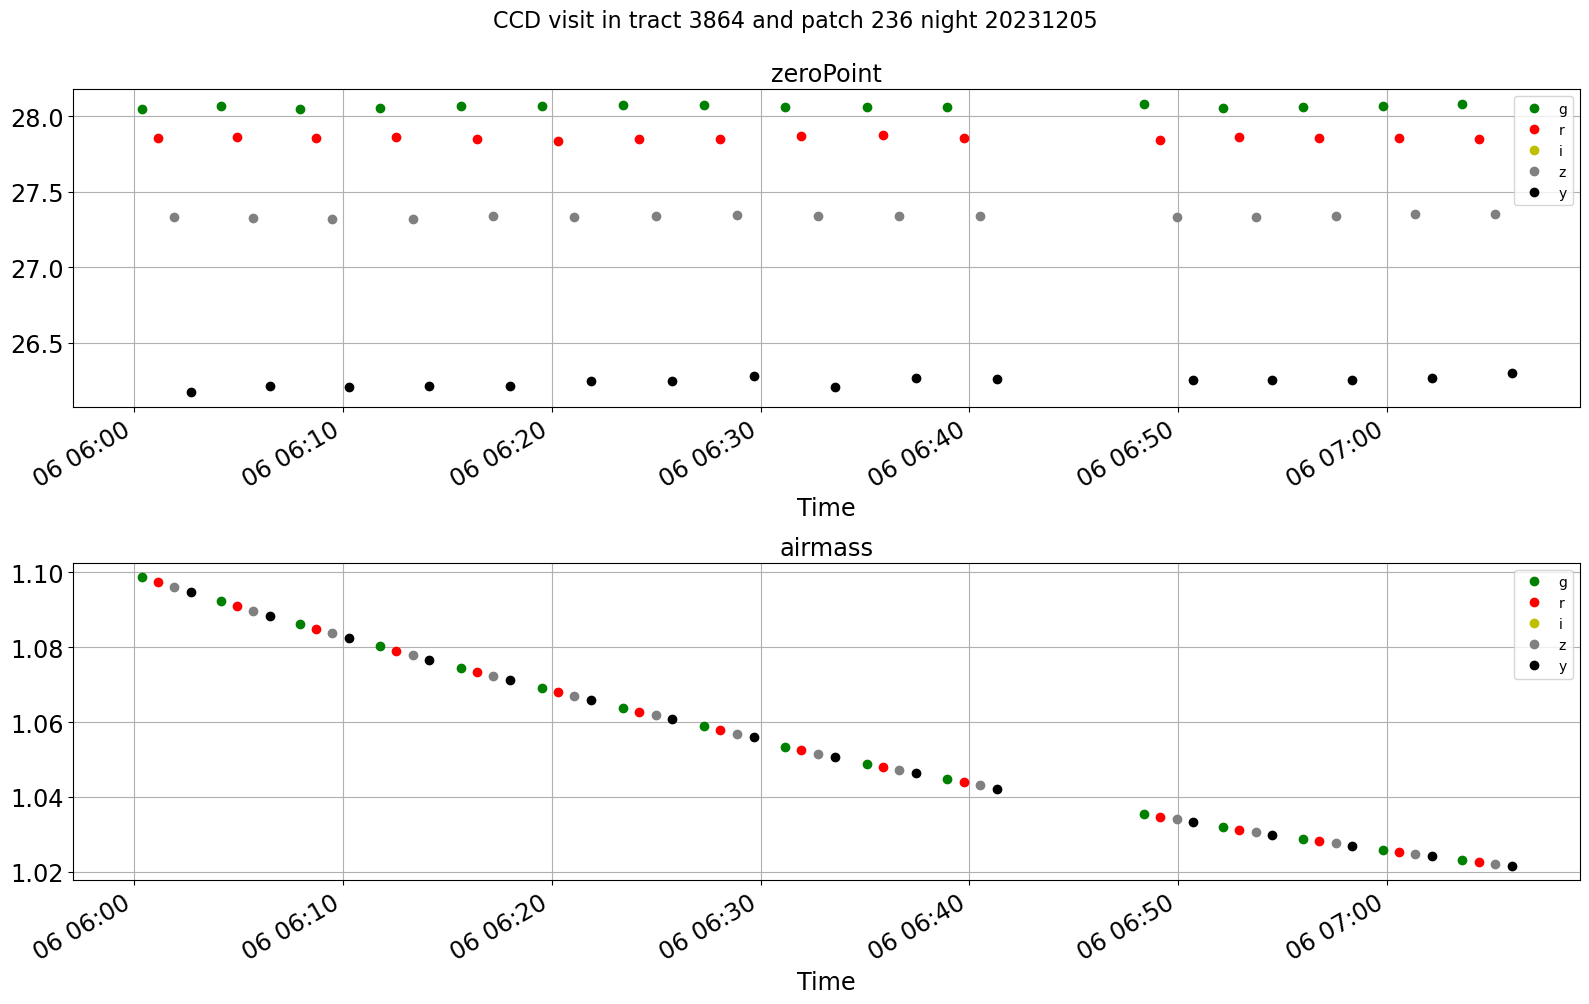

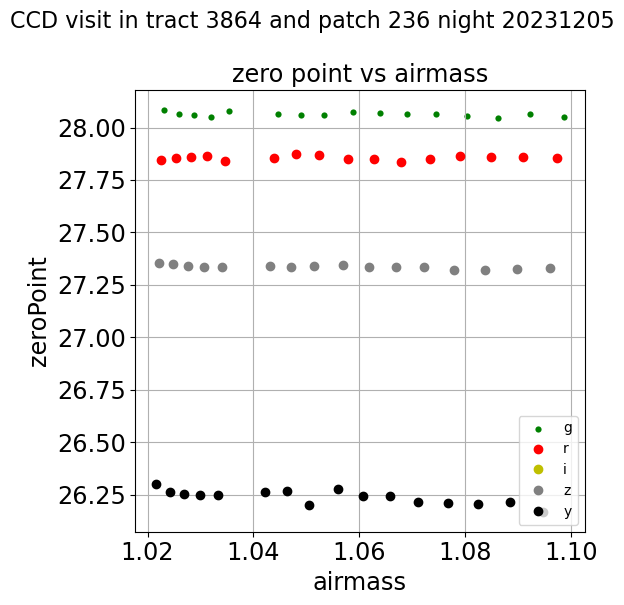

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


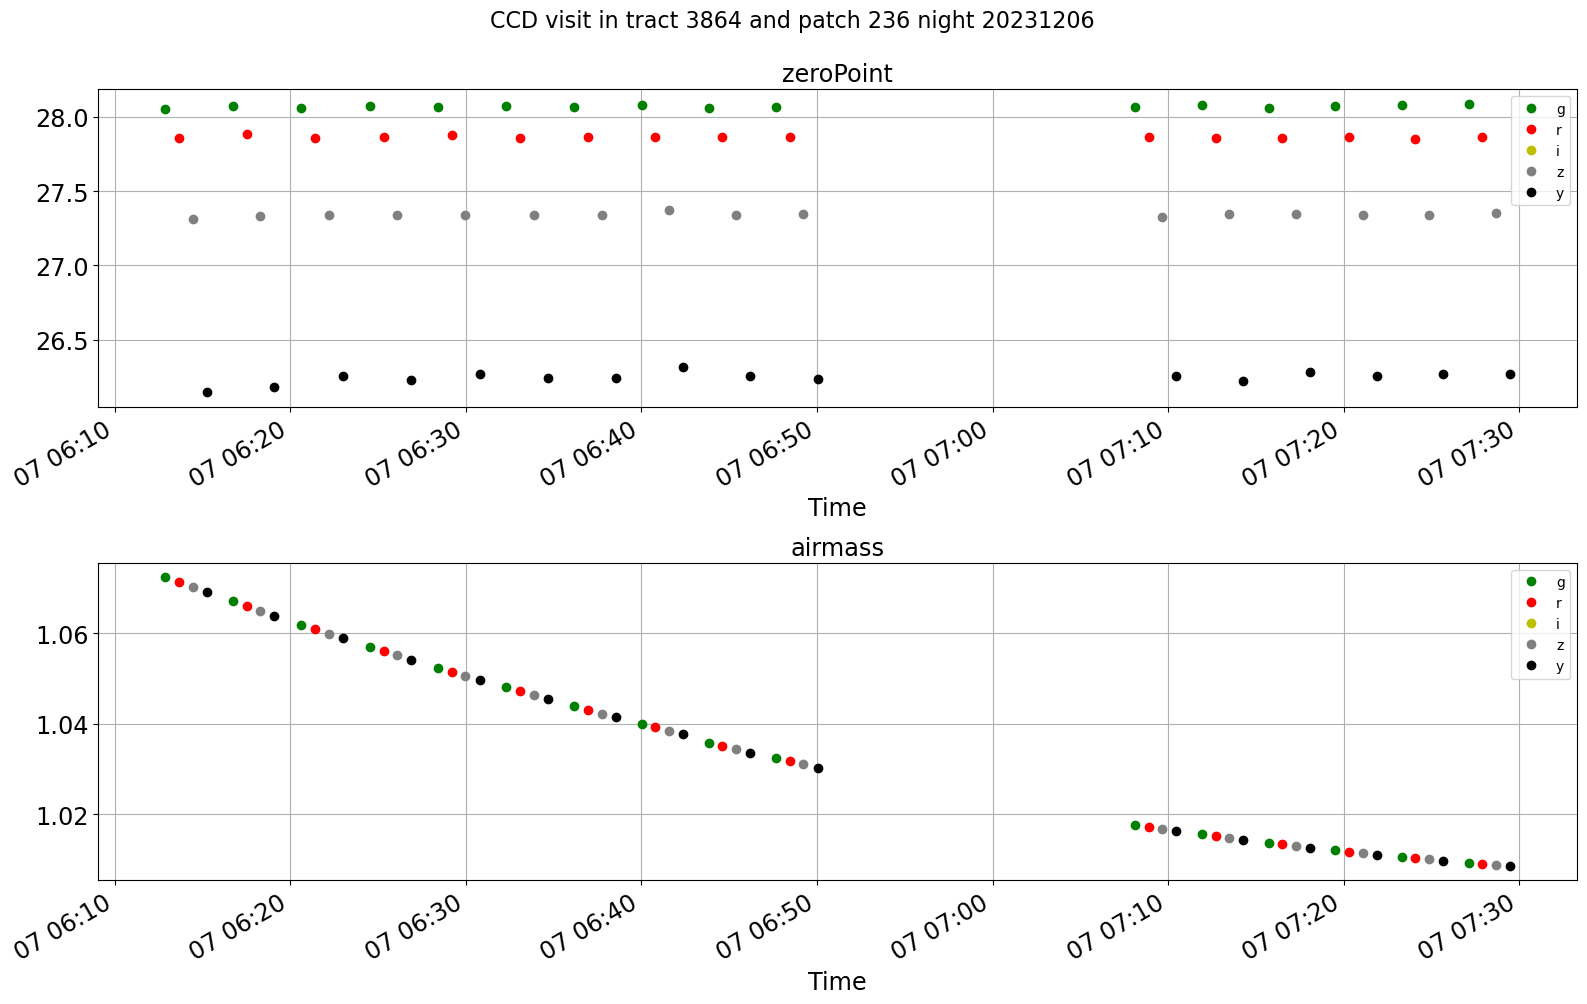

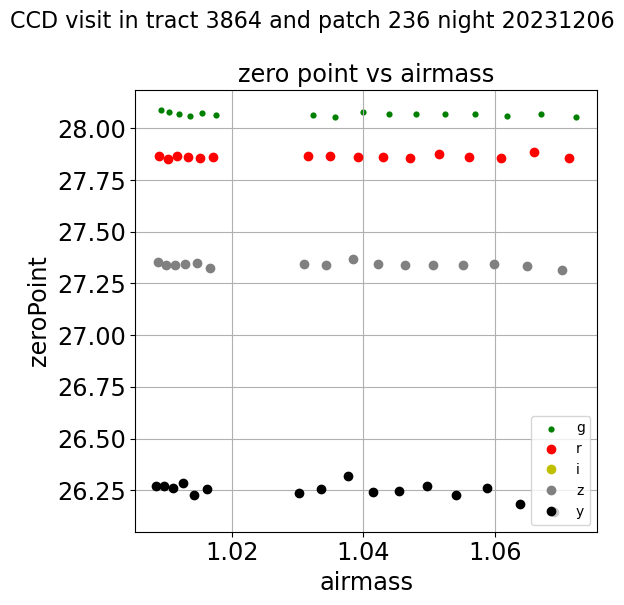

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


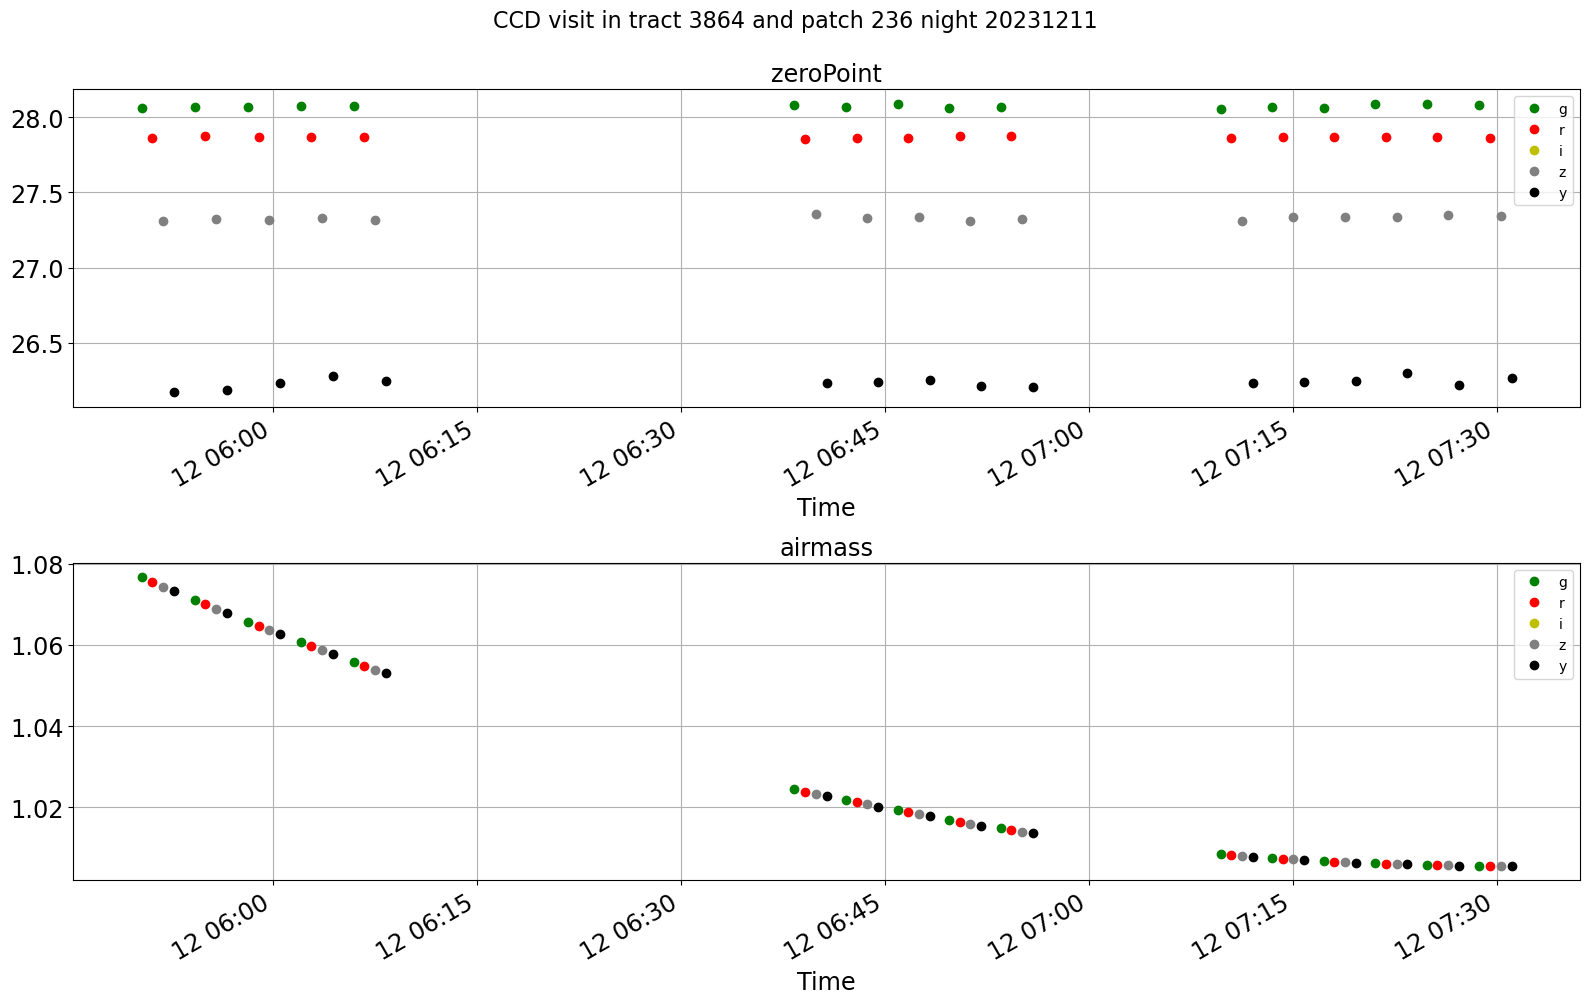

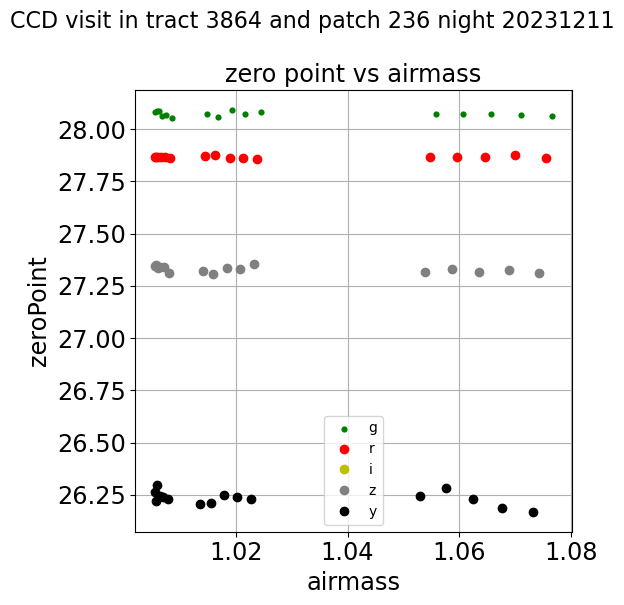

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


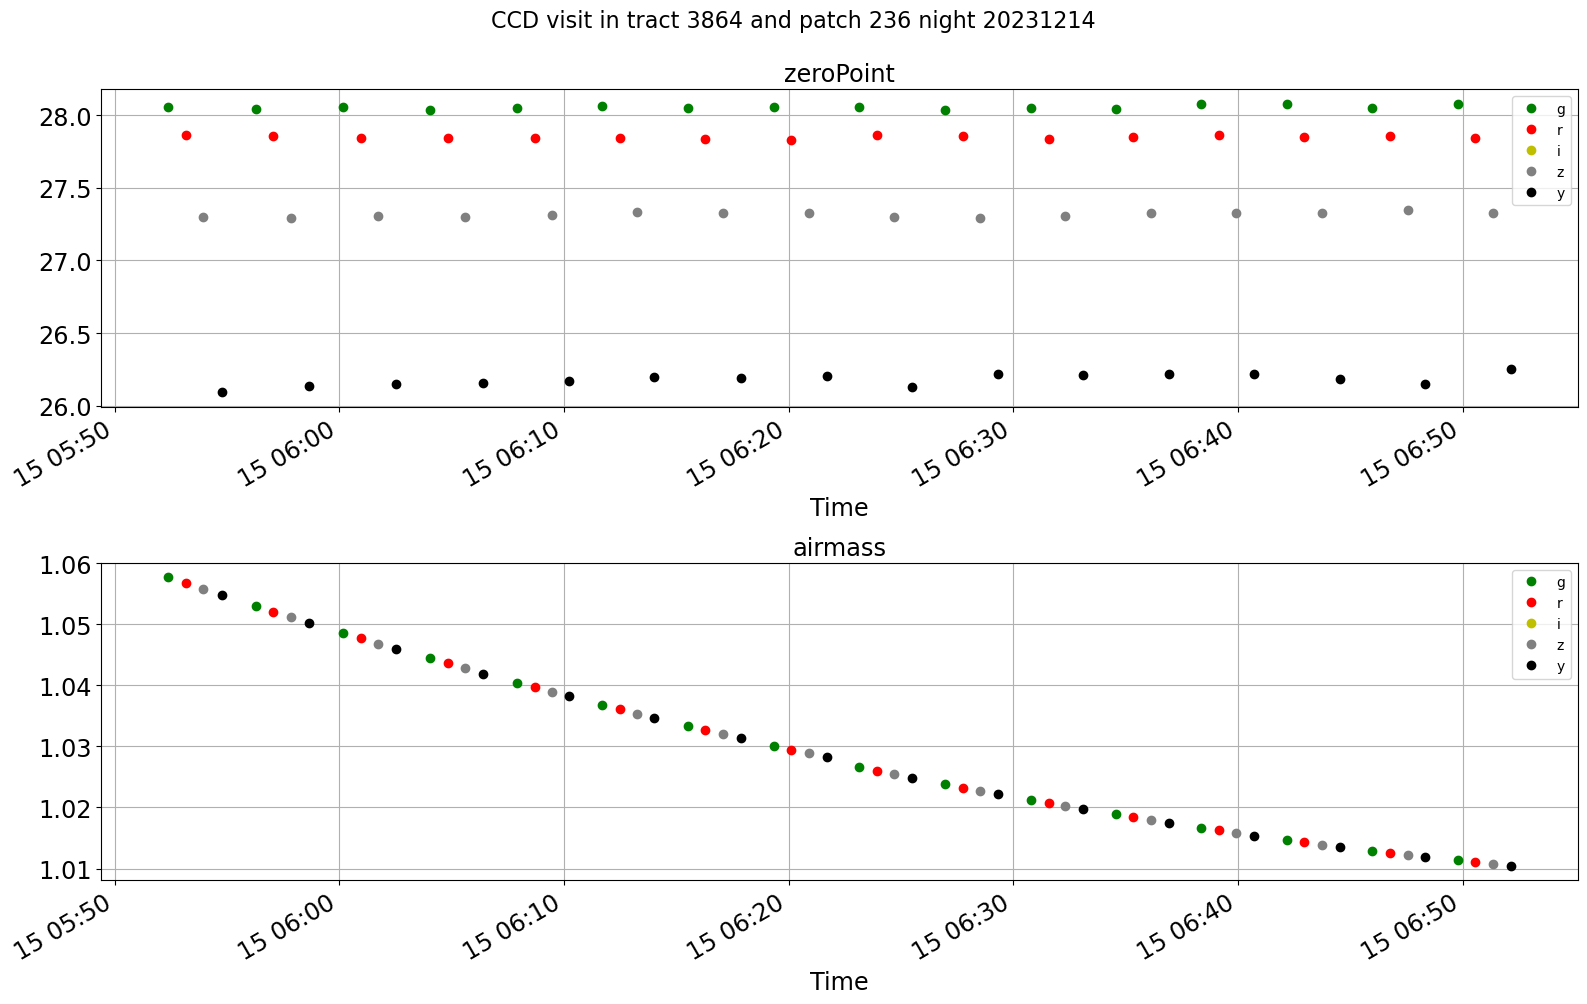

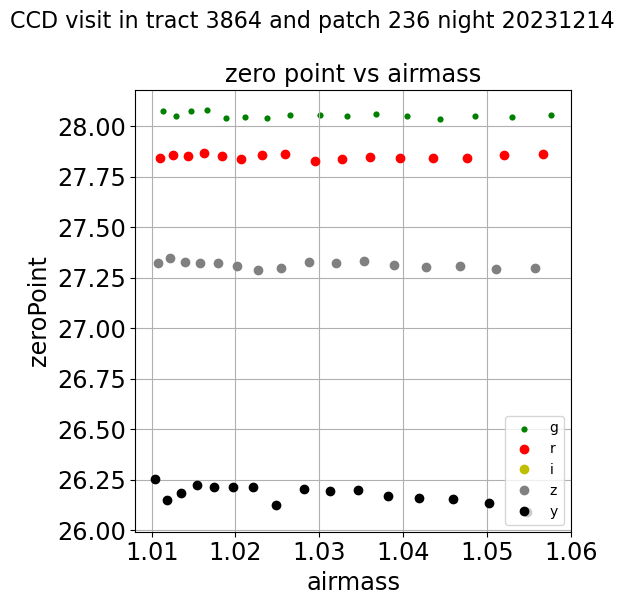

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


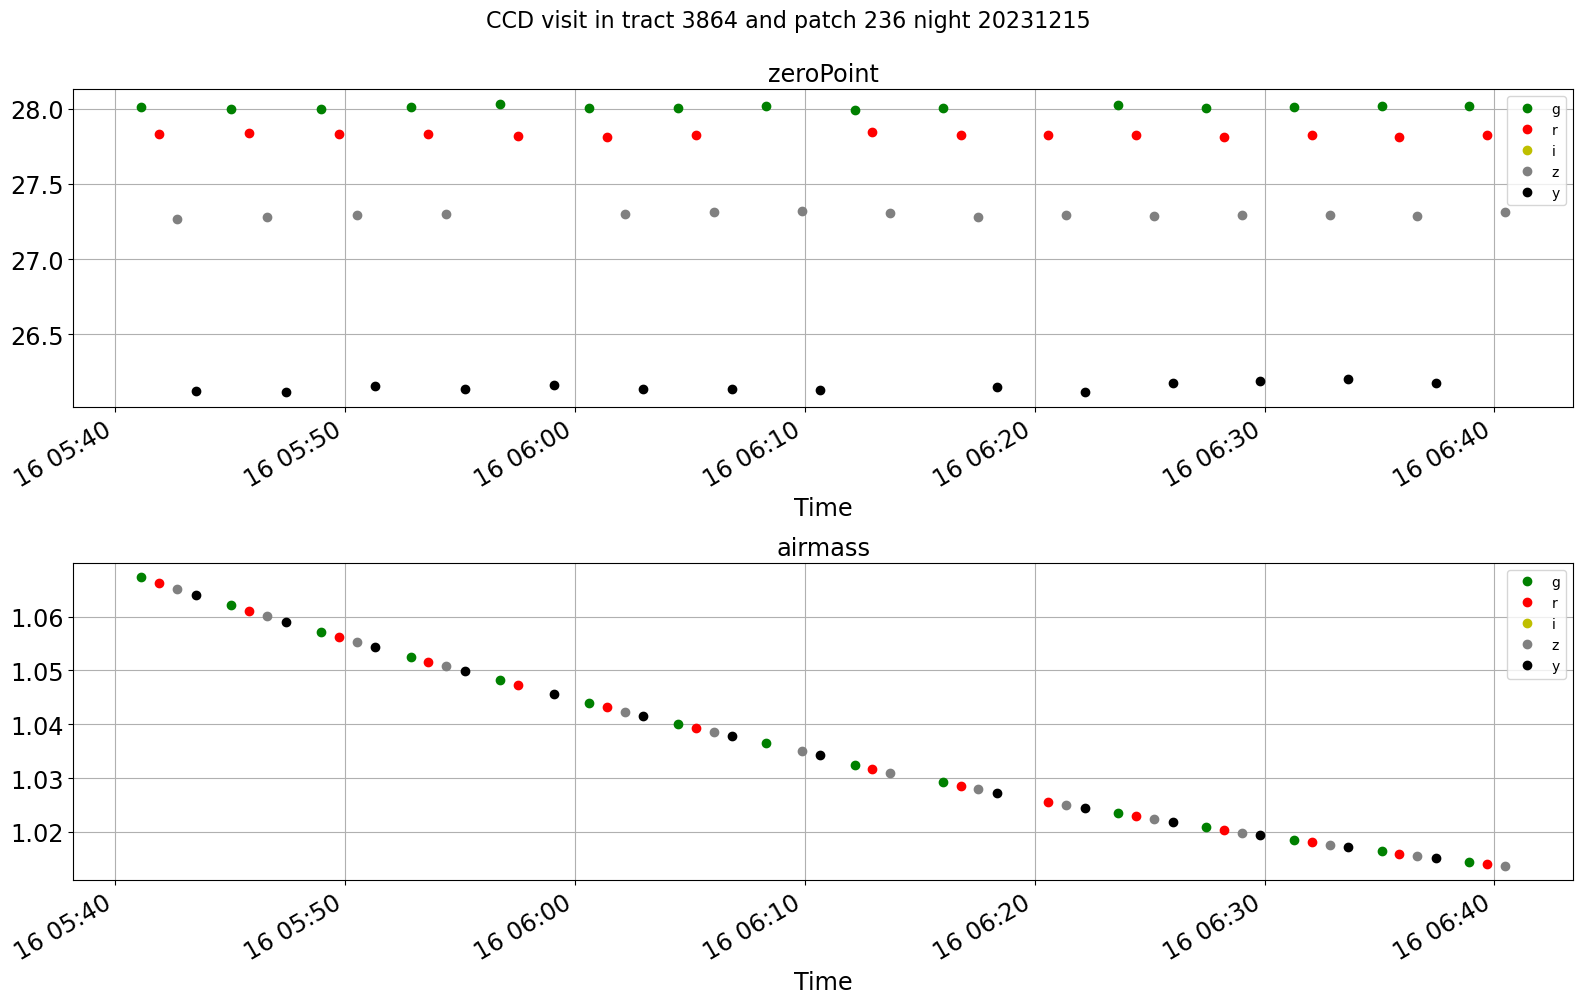

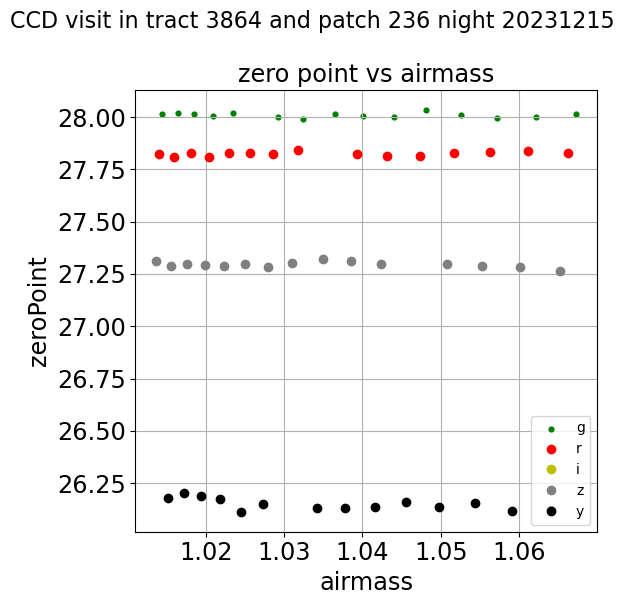

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


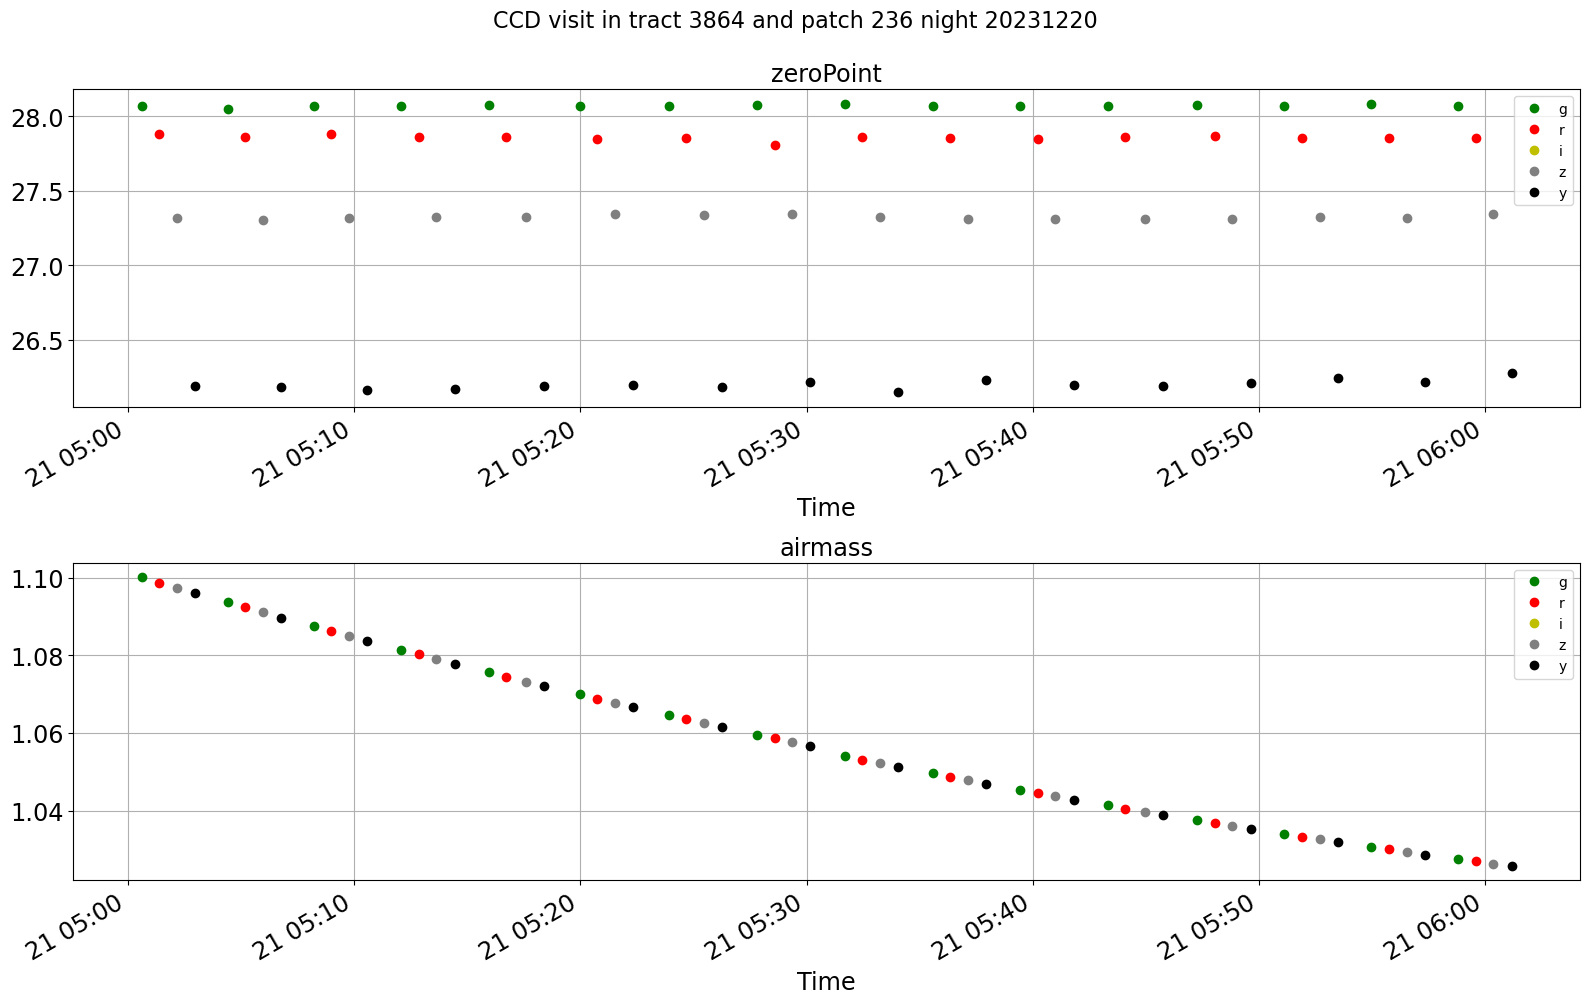

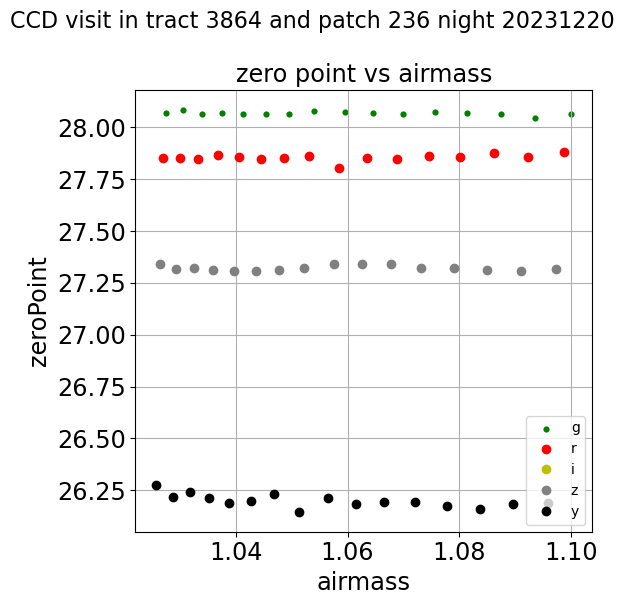

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


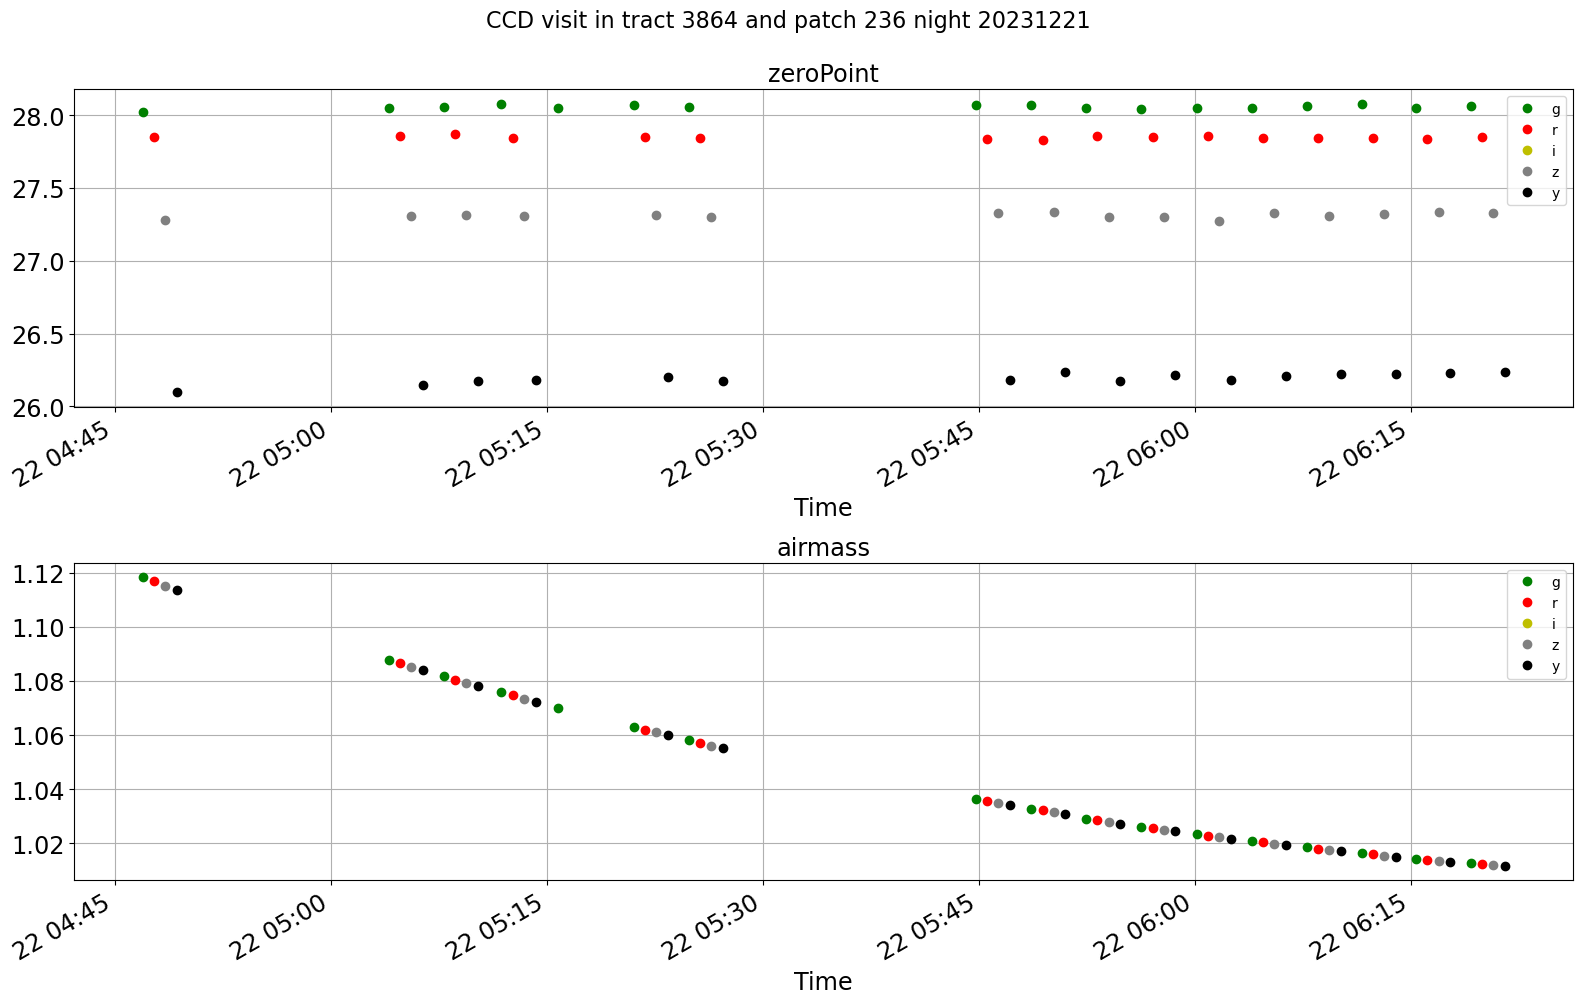

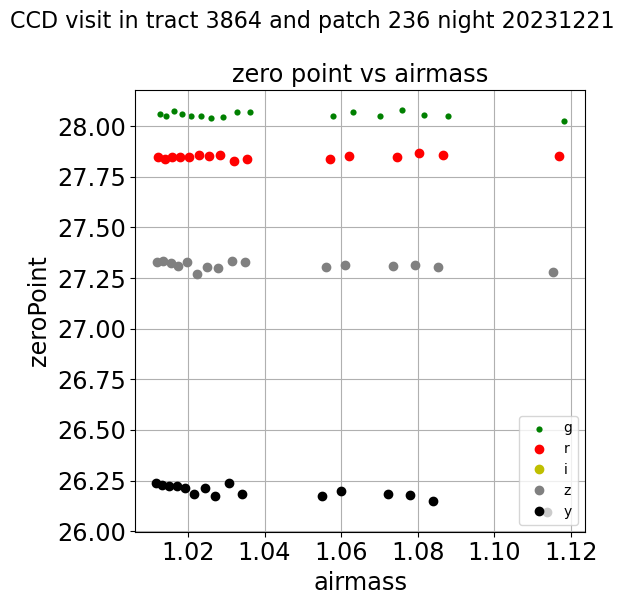

/tmp/ipykernel_18486/1659645231.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]


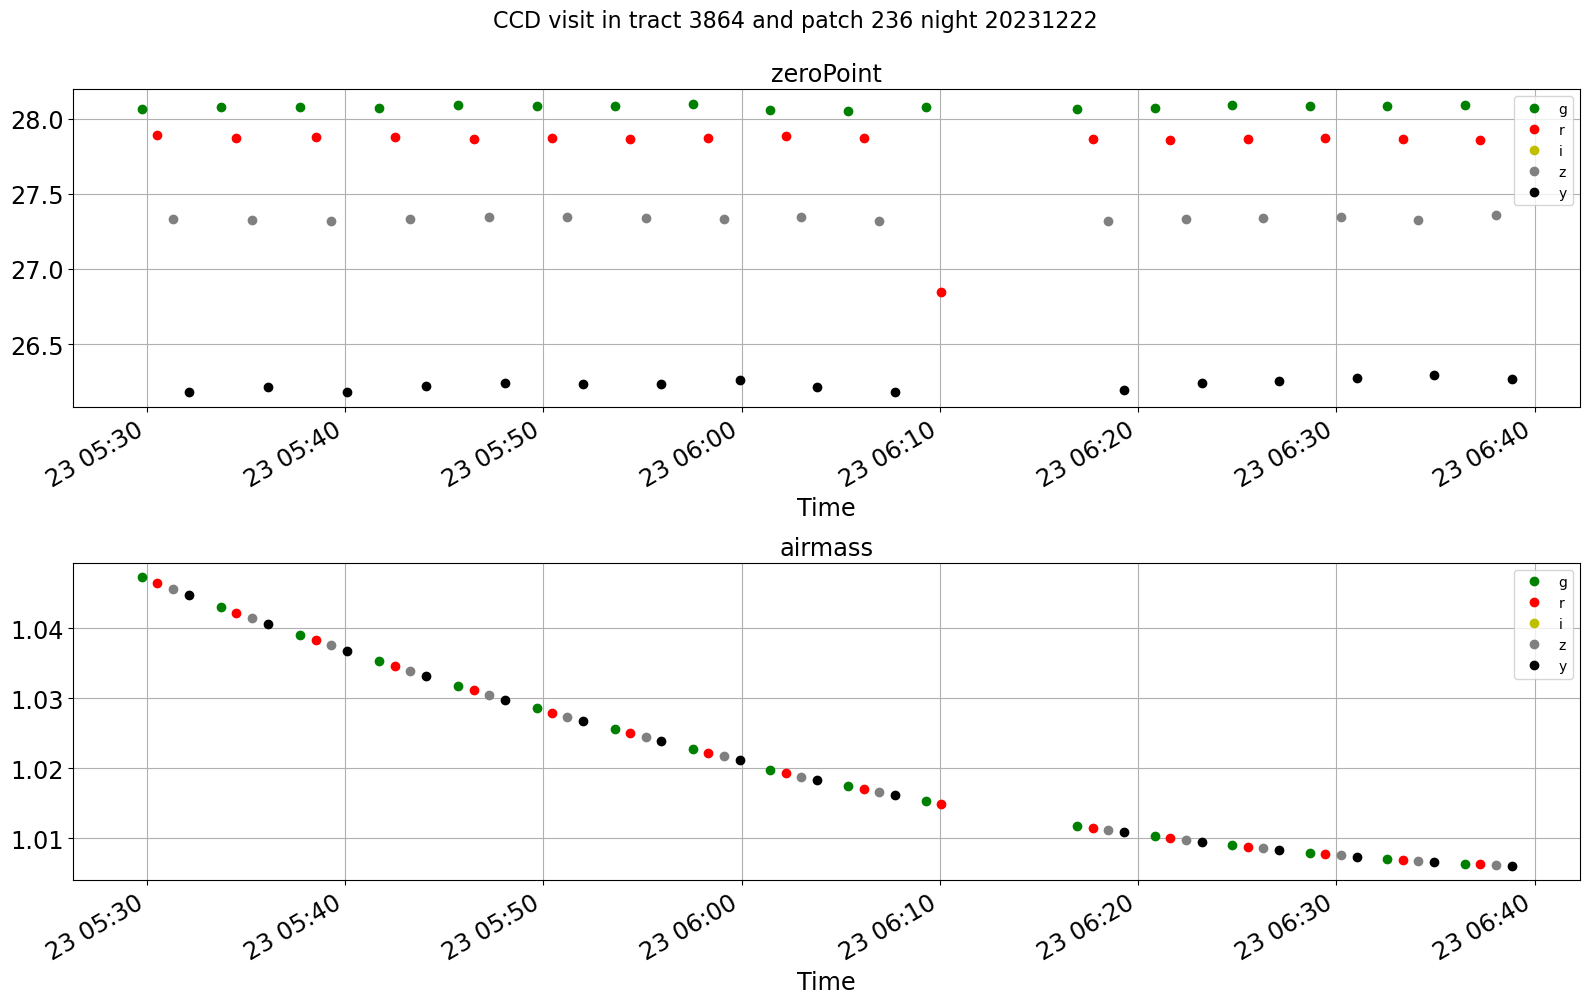

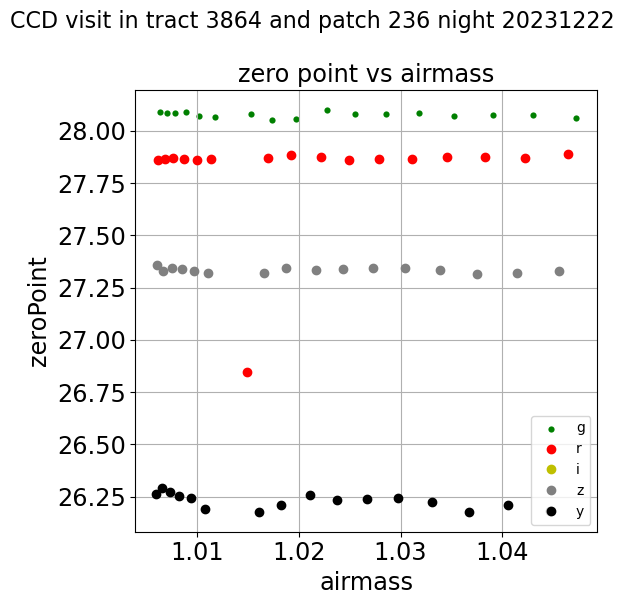

In [49]:

for nightObs_selected in all_night_obs:
    ccd_visit_table_nightsel = ccd_visit_table_selected[ccd_visit_table.nightObs == nightObs_selected]
    ccd_visit_table_nightselcount_byband = ccd_visit_table_nightsel.groupby(['band']).count()["visitId"]
    ccd_visit_table_nightselcountsum = ccd_visit_table_nightselcount_byband.sum() 
    df = ccd_visit_table_nightsel

    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
    df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,label="g")
    df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,label="r")
    df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,label="i")
    df[df["band"]=="z"].plot(x="Time",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
    df[df["band"]=="y"].plot(x="Time",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax1,grid=True,label="y")
    ax1.set_title("zeroPoint")

    df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,label="g")
    df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,label="r")
    df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,label="i")
    df[df["band"]=="z"].plot(x="Time",y="airmass",marker='o',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
    df[df["band"]=="y"].plot(x="Time",y="airmass",marker='o',c="k",lw=0.0,ax=ax2,grid=True,label="y")
    ax2.set_title("airmass")
    plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
    plt.tight_layout()
    plt.show()

    fig,ax = plt.subplots(1,1,figsize=(6,6))

    df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,label="g")
    df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,label="r")
    df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,label="i")
    df[df["band"]=="z"].plot(x="airmass",y="zeroPoint",marker='o',c="grey",lw=0.0,ax=ax,grid=True,label="z")
    df[df["band"]=="y"].plot(x="airmass",y="zeroPoint",marker='o',c="k",lw=0.0,ax=ax,grid=True,label="y")
    ax.set_title("zero point vs airmass")

    plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
    plt.tight_layout()
    plt.show()



# Selection of visits

In [50]:
Selected_Nights = [20231121, 20231127, 20231128,20231129, 20231130, 20231204, 20231205, 20231206, 20231211,20231214, 20231215, 20231220, 20231221, 20231222]

In [51]:
all_df_visits_selected = []
for nightobs in Selected_Nights:
    cut_sel = ccd_visit_table_selected["nightObs"] == nightobs
    df = ccd_visit_table_selected[cut_sel]
    df_subset = df[["nightObs","visitId","physical_filter","band","zeroPoint","expMidptMJD","obsStart","obsStartMJD","Time","airmass","patchID","tractID"]]
    all_df_visits_selected.append(df_subset)

In [52]:
all_df_visits_selected = pd.concat(all_df_visits_selected)

In [53]:
all_df_visits_selected.set_index("visitId",inplace=True) 

In [54]:
all_df_visits_selected.sort_index(inplace=True)

In [55]:
all_df_visits_selected

,nightObs,physical_filter,band,zeroPoint,expMidptMJD,obsStart,obsStartMJD,Time,airmass,patchID,tractID
visitId,,,,,,,,,,,
2023112100506,20231121,SDSSg_65mm~empty,g,28.037331,60270.293207,2023-11-22 07:01:58.064996,60270.293033,2023-11-22 07:01:58.064996,1.087878,3864,237
2023112100507,20231121,SDSSr_65mm~empty,r,27.826233,60270.293745,2023-11-22 07:02:44.576007,60270.293571,2023-11-22 07:02:44.576007,1.086620,3864,237
2023112100508,20231121,SDSSz_65mm~empty,z,27.281532,60270.294284,2023-11-22 07:03:31.156006,60270.294111,2023-11-22 07:03:31.156006,1.085371,3864,237
2023112100509,20231121,empty~SDSSy_65mm,y,26.175438,60270.294842,2023-11-22 07:04:19.313506,60270.294668,2023-11-22 07:04:19.313506,1.084094,3864,237
2023112100510,20231121,SDSSg_65mm~empty,g,28.049168,60270.295844,2023-11-22 07:05:45.944508,60270.295671,2023-11-22 07:05:45.944508,1.081935,3864,236
...,...,...,...,...,...,...,...,...,...,...,...
2023122200530,20231222,empty~SDSSy_65mm,y,26.290859,60301.274438,2023-12-23 06:34:56.432498,60301.274264,2023-12-23 06:34:56.432498,1.006569,3864,236
2023122200531,20231222,SDSSg_65mm~empty,g,28.088020,60301.275506,2023-12-23 06:36:28.743997,60301.275333,2023-12-23 06:36:28.743997,1.006333,3864,236
2023122200532,20231222,SDSSr_65mm~empty,r,27.858763,60301.276044,2023-12-23 06:37:15.228995,60301.275871,2023-12-23 06:37:15.228995,1.006219,3864,236


In [56]:
file_selectedvisits = f"SelectedVisits_fall2023_tract_{tract_selected}.csv"

In [57]:
all_df_visits_selected.to_csv(file_selectedvisits)